In [10]:
"""
    Importeer libraries
    """
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from math import sqrt, ceil
from scipy.stats import linregress    
import libraries as lib
import math 
    

In [11]:
# Set Lees GPS data met hoogte-data in
"""
    Maak dataframe  met hoogte data.

    Parameters:
        file_path: directory van het bestand met hoogteprofiel

    Returns:
        DataFrame: Het dataframe met hoogte data.
    """

file_path = "C:/Users/qvled/OneDrive - HvA/Clean_Mobility_Files/H2A/Data voor hoogteprofiel.txt"

# Read GPS data
hoogte_df = lib.lees_gps_data(file_path)

# Print the resulting DataFrame
hoogte_df


,timestamp,latitude,lat_direction,longitude,lon_direction,hoogte,speed_m/s
0,063448.30,43.771393,N,-0.042098,W,99.5,0.038583
1,063448.40,43.771393,N,-0.042098,W,99.5,0.026237
2,063448.50,43.771393,N,-0.042098,W,99.4,0.035497
3,063448.60,43.771393,N,-0.042098,W,99.5,0.073051
4,063448.70,43.771393,N,-0.042098,W,99.4,0.064820
...,...,...,...,...,...,...,...
46568,None,43.771202,N,-0.041941,W,96.0,NaN
46569,None,43.771202,N,-0.041941,W,96.0,NaN
46570,None,43.771202,N,-0.041941,W,96.1,NaN
46571,None,43.771202,N,-0.041941,W,96.1,NaN


In [12]:
#Filter vanaf het moment dat de auto de baan opgaat en wanneer die er weer afgaat.
"""
    Filter de data handmatig vanaf een opgegeven startrij tot een opgegeven eindrij.

    Parameters:
        data_file_motordriver (DataFrame): Het originele DataFrame.
        start_row (int): Het indexnummer van de rij waarmee het filteren moet beginnen.
        end_row (int): Het indexnummer van de rij waarmee het filteren moet eindigen.

    Returns:
        DataFrame: Het gefilterde DataFrame vanaf start_row tot end_row.
    """
# Definieer de coördinaten voor het start- en eindpunt
start_lon = -0.0446
start_lat = 0.00095 + 4.3771e1
end_lon = -0.039925
end_lat = 0.000300 + 4.3771e1

# Veronderstel dat 'df' je DataFrame is met de relevante data
filtered_hoogte_df = lib.filter_track_data(hoogte_df, start_lon, start_lat, end_lon, end_lat)

# Print het gefilterde DataFrame om te controleren
filtered_hoogte_df
#43.767914, -0.035855

,timestamp,latitude,lat_direction,longitude,lon_direction,hoogte,speed_m/s
22340,071203.60,43.771951,N,-0.044597,W,102.0,5.597156
22341,071203.70,43.771954,N,-0.044603,W,102.0,5.624421
22342,071203.80,43.771955,N,-0.044609,W,102.0,5.633167
22343,071203.90,43.771958,N,-0.044616,W,102.0,5.650143
22344,071204.00,43.771960,N,-0.044622,W,102.0,5.655288
...,...,...,...,...,...,...,...
42943,074720.40,43.771037,N,-0.040149,W,98.1,8.270209
42944,074720.50,43.771032,N,-0.040142,W,98.1,8.298503
42945,074720.60,43.771027,N,-0.040135,W,98.1,8.276382
42946,074720.70,43.771022,N,-0.040127,W,98.1,8.287700


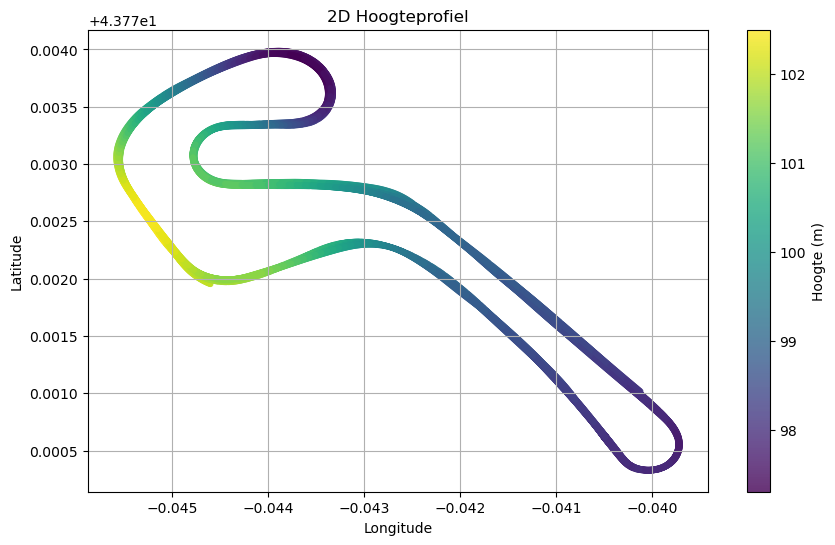

In [13]:
# Maak hoogteprofiel van de baan
"""
    Visualiseert het hoogteprofiel van de racebaan.

    Parameters:
    latitudes (pd.Series of list): Lijst of Pandas Series met breedtegraden van de meetpunten.
    longitudes (pd.Series of list): Lijst of Pandas Series met lengtegraden van de meetpunten.
    hoogtes (pd.Series of list): Lijst of Pandas Series met hoogtes boven zeeniveau van de meetpunten.

    Returns:
    None
    """
lib.plot_height_profile(filtered_hoogte_df['latitude'], filtered_hoogte_df['longitude'], filtered_hoogte_df['hoogte'])


Indices van punten in de twee gebieden: [962, 1282, 3058, 3356, 5066, 5370, 7068, 7372, 9238, 9561, 11378, 11698, 13580, 13908, 15782, 16107, 18039, 18370, 20317]


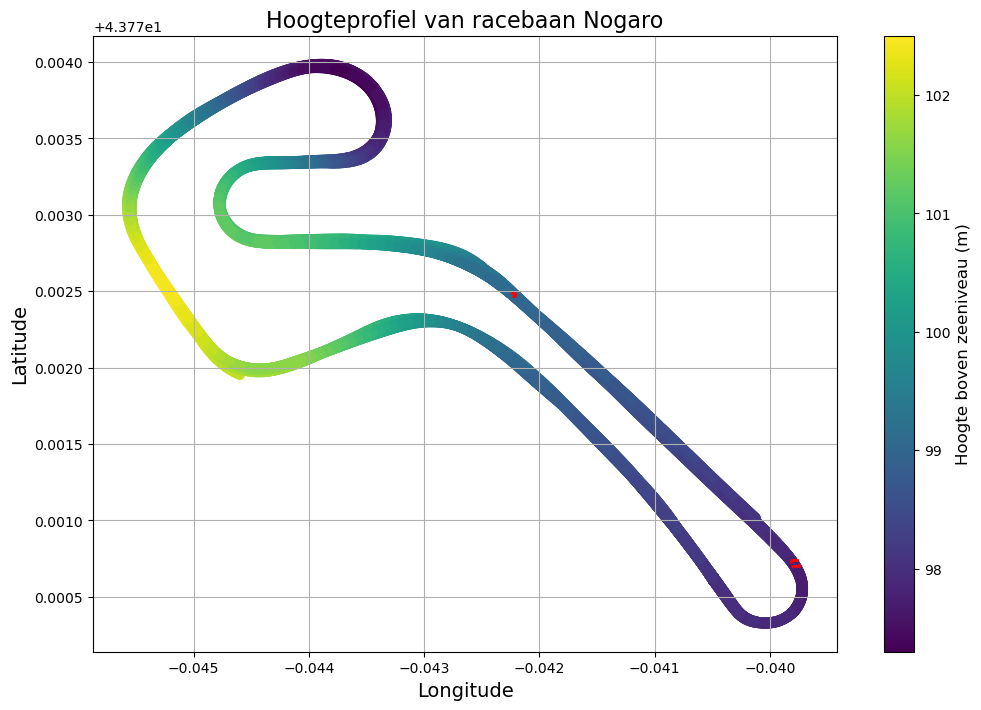

In [14]:
#Zoekt de rijen van stukken die je wilt definiëren, eerste index is begin, 2e index is eind.
"""
    Identificeert de indices van rijen in de DataFrame die binnen twee opgegeven rechthoekige gebieden vallen.

    Parameters:
    df (DataFrame): De DataFrame met 'latitude' en 'longitude' kolommen.
    lat_min1, lat_max1, lon_min1, lon_max1: Coördinaten van het eerste gebied.
    lat_min2, lat_max2, lon_min2, lon_max2: Coördinaten van het tweede gebied.

    Returns:
    list: Lijst met indices van de rijen die binnen de opgegeven gebieden vallen.
    """
lat_min1, lat_max1 = 7e-5 + 4.37724e1, 8.6e-5 + 4.37724e1
lon_min1, lon_max1 = -0.04224, -0.04221

lat_min2, lat_max2 = 70e-5 + 4.377e1, 74e-5 + 4.377e1
lon_min2, lon_max2 = -0.03982, -0.03975

indices = lib.vind_rijen(
    filtered_hoogte_df,
    lat_min1, lat_max1, lon_min1, lon_max1,
    lat_min2, lat_max2, lon_min2, lon_max2
)
print("Indices van punten in de twee gebieden:", indices)

# plot de boxes in de figuur
"""
    Visualiseert het hoogteprofiel van een racebaan met aangegeven rechthoekige gebieden.

    Parameters:
    latitudes (pd.Series of list): Lijst of Pandas Series met breedtegraden van de meetpunten.
    longitudes (pd.Series of list): Lijst of Pandas Series met lengtegraden van de meetpunten.
    hoogtes (pd.Series of list): Lijst of Pandas Series met hoogtes boven zeeniveau van de meetpunten.
    lat_min1, lat_max1, lon_min1, lon_max1 (float): Coördinaten die de grenzen van het eerste rechthoekige gebied definiëren.
    lat_min2, lat_max2, lon_min2, lon_max2 (float): Coördinaten die de grenzen van het tweede rechthoekige gebied definiëren.

    Functionaliteit:
    - Maakt een scatterplot van de opgegeven GPS-coördinaten, gekleurd op basis van hoogte.
    - Geeft twee rechthoekige gebieden weer op de kaart met rode stippellijnen.
    - Voegt een kleurenschaal toe om de hoogtewaarden te interpreteren.
    - Voorziet de plot van titels en labels voor duidelijkheid.

    Returns:
    None
    """
lib.plot_height_profile_with_boxes(filtered_hoogte_df['latitude'], filtered_hoogte_df['longitude'],filtered_hoogte_df['hoogte'], 
lat_min1, lat_max1, lon_min1, lon_max1,
lat_min2, lat_max2, lon_min2, lon_max2)


In [15]:
#Maak een df met de hoogte en afstand toegevoegd (voor maken hoogteprofiel fit)
"""
    Selecteer een subset van de DataFrame op basis van het opgegeven indexbereik,
    verwijder de kolom 'speed(m/s)', bereken de Haversine-afstand en het hoogteverschil
    tussen opeenvolgende rijen, en voeg deze als nieuwe kolommen toe aan het subset.

    Parameters:
    df (DataFrame): De oorspronkelijke DataFrame met de kolommen 'latitude', 'longitude',
                    'lat_direction', 'lon_direction', 'hoogte' en 'speed(m/s)'.
    start_index (int): De startindex van de rijen die moeten worden verwerkt.
    eind_index (int): De eindindex (inclusief) van de rijen die moeten worden verwerkt.

    Returns:
    DataFrame: Een subset van de oorspronkelijke DataFrame zonder de kolom 'speed(m/s)' en met
               extra kolommen 'afstand', 'hoogteverschil', 'cumulatieve_afstand' en
               'cumulatief_hoogteverschil'.
    """
start_index = 25271
eind_index = 25710

hoogte_met_afstand_df = lib.bereken_afstand_en_hoogteverschil(filtered_hoogte_df, start_index, eind_index)
hoogte_met_afstand_df


,timestamp,latitude,lat_direction,longitude,lon_direction,hoogte,afstand,hoogteverschil,cumulatieve_afstand,cumulatief_hoogteverschil
25271,071710.30,43.772813,N,-0.043600,W,100.5,0.000000,0.0,0.000000,0.0
25272,071710.40,43.772813,N,-0.043589,W,100.5,0.843887,0.0,0.843887,0.0
25273,071710.60,43.772813,N,-0.043579,W,100.5,0.843276,0.0,1.687162,0.0
25274,071710.70,43.772813,N,-0.043568,W,100.5,0.856655,0.0,2.543817,0.0
25275,071710.80,43.772812,N,-0.043558,W,100.5,0.843887,0.0,3.387704,0.0
...,...,...,...,...,...,...,...,...,...,...
25706,071756.90,43.770671,N,-0.039759,W,97.8,0.807888,0.0,401.889518,-2.7
25707,071757.00,43.770664,N,-0.039755,W,97.8,0.802661,0.0,402.692179,-2.7
25708,071757.10,43.770657,N,-0.039751,W,97.8,0.819808,0.0,403.511987,-2.7
25709,071757.20,43.770650,N,-0.039748,W,97.8,0.792783,0.0,404.304770,-2.7


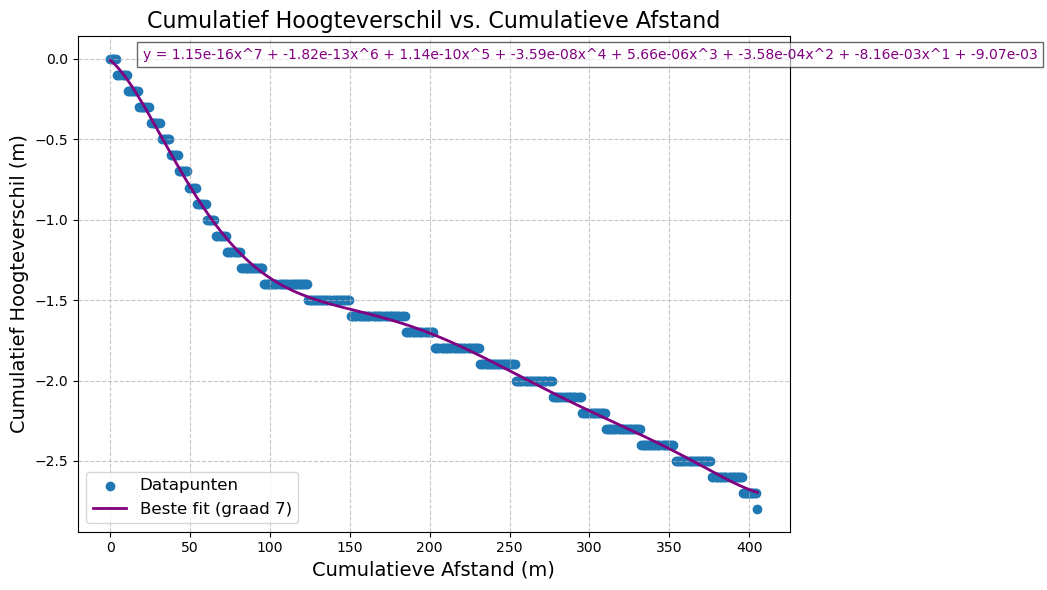

y = 1.15e-16x^7 + -1.82e-13x^6 + 1.14e-10x^5 + -3.59e-08x^4 + 5.66e-06x^3 + -3.58e-04x^2 + -8.16e-03x^1 + -9.07e-03


In [16]:
#Maak een fitvergelijking voor het hoogteprofiel van dit df
#Voeg de polynoom in
"""
    Parameters:
    dataframe (pd.DataFrame): DataFrame met de kolommen 'cumulatieve_afstand' en 'cumulatief_hoogteverschil'.
    polynoom_graad (int): De graad van de polynoom die aan de data wordt aangepast.
"""

polynomial = lib.plot_hoogte_vs_afstand_met_fit(hoogte_met_afstand_df, 7)


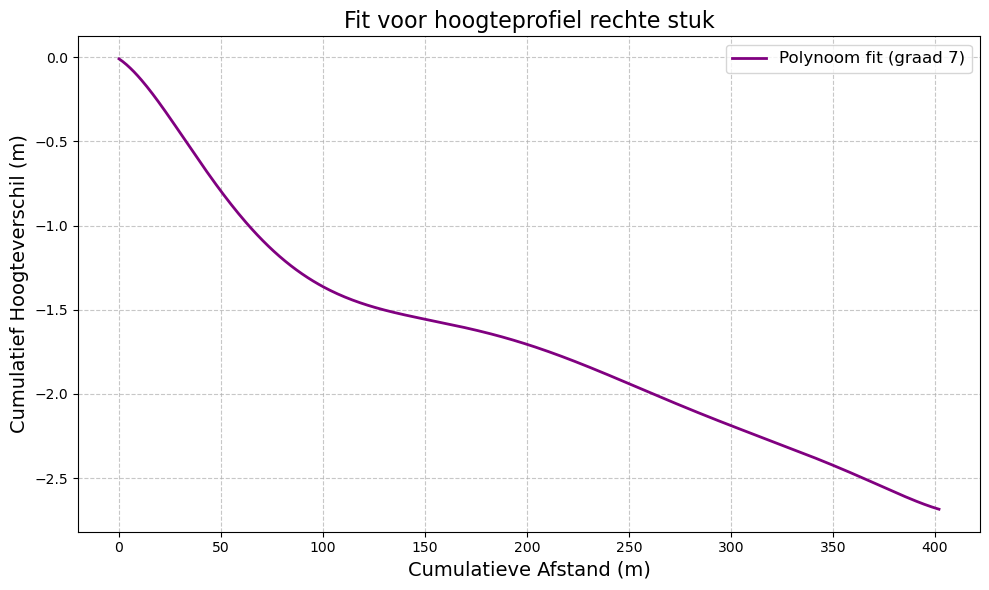

In [17]:
    """
    Plot de polynoomfit over een gespecificeerd bereik met een bepaald aantal punten.

    Parameters:
    polynomial (np.poly1d): De polynoom die aan de data is aangepast.
    x_fit_range (tuple): Een tuple met (start, stop) waarden voor het x-bereik.
    aantal_punten (int): Het aantal punten om te genereren tussen start en stop.

    Returns:
    None
    """

# Plotten van de polynoomfit over een specifiek bereik met een bepaald aantal punten
lib.plot_polynomial_fit(polynomial, (0, 402), 440)


In [20]:
"""
    Laadt motordriver-data in, selecteert een subset van rijen, corrigeert GPS-coördinaten
    en voegt snelheden in m/s toe.

    Parameters:
    directory (str): Pad naar de directory met het databestand.
    file_motordriver (str): Naam van het motordriver-databestand.
    start_row (int): Startindex van de te selecteren rijen (inclusief).
    end_row (int): Eindindex van de te selecteren rijen (inclusief).

    Returns:
    pd.DataFrame: Geprocessed DataFrame met geselecteerde rijen, gecorrigeerde GPS-coördinaten
                  en snelheden in m/s.
    """

directory = "C:/Users/qvled/OneDrive - HvA/Logfiles/H2A/2023/Nogaro/20230525_h2a_poging1/0002/"
file_motordriver = "5.csv"
start_row = 223257
end_row = 479444

file_motordriver = lib.verwerk_motordriver_data(directory, file_motordriver, start_row, end_row)
filtered_motordriver

NameError: name 'lib' is not defined

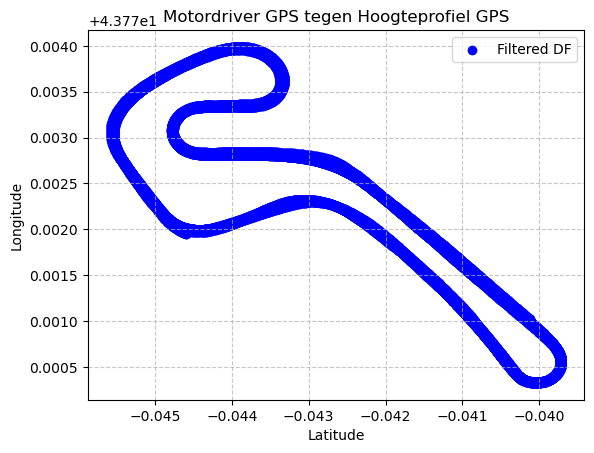

In [23]:
plt.title('Motordriver GPS tegen Hoogteprofiel GPS')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
#plt.scatter(filtered_motordriver['GPS longitude, in graden'], filtered_motordriver['GPS latitude, in graden'], color ='r', label= 'Filtered_motordriver')
plt.scatter(filtered_hoogte_df['longitude'], filtered_hoogte_df['latitude'], color='b', label='Filtered DF')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

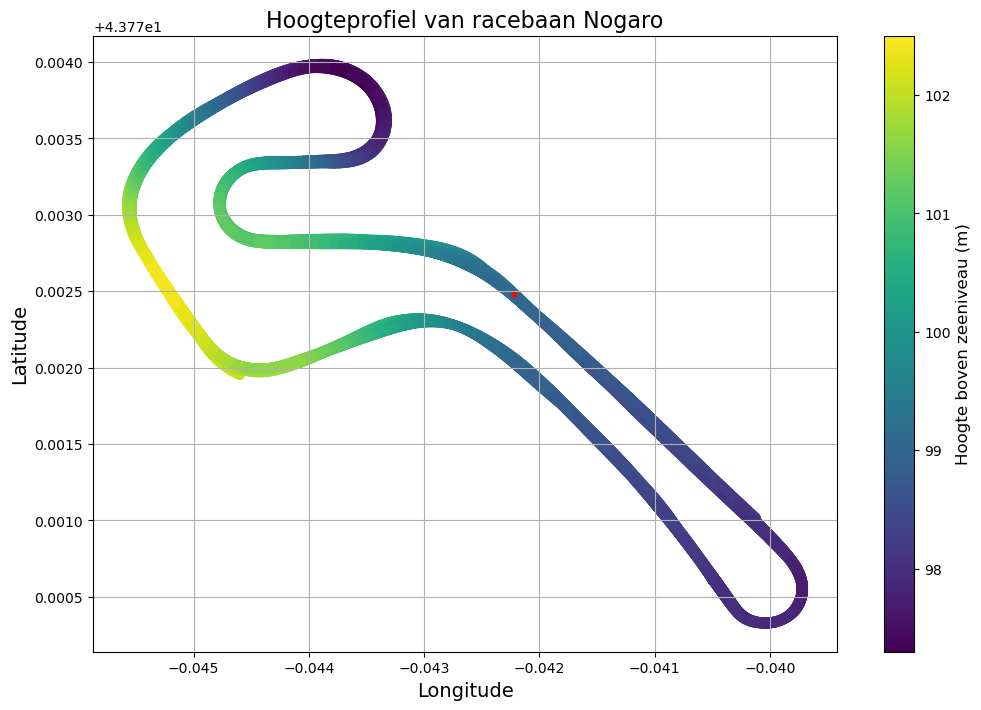

In [16]:
#Check of het is gelukt met de rondes
#Het is gelukt

def plot_hoogteprofiel_2d(latitudes, longitudes, hoogtes):
    # Increase figure size by setting the figsize
    fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height as needed
    scatter = ax.scatter(longitudes, latitudes, c=hoogtes, cmap='viridis', marker='o')
    ax.set_title('Hoogteprofiel van racebaan Nogaro', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # Create the colorbar
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Hoogte boven zeeniveau (m)', fontsize=12)

    # Plot the rectangular boundaries
    plt.plot(
        [lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='red', linestyle='--', linewidth=2, label="Boundary Square")

    for i in range(len(latitudes)):
        lat = latitudes.iloc[i]
        lon = longitudes.iloc[i]
        #plt.text(lon, lat, str(i), fontsize=8, color='black')

    # Enable grid
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Assuming `df` is your DataFrame with columns: 'latitude', 'longitude', and 'hoogte'
plot_hoogteprofiel_2d(filtered_df['latitude'], filtered_df['longitude'], filtered_df['hoogte'])


In [17]:
#Maken df's per ronde motordriver
begin_eind_paren2 = [
    (0, 26251), 
    (26251, 49486), 
    (49486, 74393), 
    (74393, 100200),
    (100200, 124732), 
    (124732, 149852), 
    (149852, 174488), 
    (174488, 200208),
    (200208, 226012), 
    (226012, 255494)
]

# Maak een lege lijst om de rondes-dataframes op te slaan
rondes = []

# Loop door elke (begin, eind) paar en maak een DataFrame subset
for i, (begin, eind) in enumerate(begin_eind_paren2):
    df_segment = filtered_motordriver.iloc[begin:eind]
    rondes.append(df_segment)

# Je kunt nu elke ronde benaderen als rondes[0], rondes[1], etc.
df_ronde1 = rondes[0]
df_ronde2 = rondes[1]
df_ronde3 = rondes[2]
df_ronde4 = rondes[3]
df_ronde5 = rondes[4]
df_ronde6 = rondes[5]
df_ronde7 = rondes[6]
df_ronde8 = rondes[7]
df_ronde9 = rondes[8]
df_ronde10 = rondes[9]

# Print het resultaat voor de eerste ronde om te controleren
df_ronde7


,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,"Toestand cruise control2-knop (aan=1, uit=0)",Tijdstip laatste verandering cruise control2-knop,"GPS longitude, in graden","GPS latitude, in graden",GPS direction,"GPS speed, in km/h","GPS time, in seconden sinds het begin van de huidige GPS-week",Checksum,"Wielsnelheid, in m/s","GPS speed, in m/s"
373109,5,5837.5808,03|04,2195.9629,21.155,7.969,180.1,114188,27.357,6.742,...,0,2131.384,-0.040835,43.770947,322.7,26.3,80035.0,NaN,7.287778,7.305556
373110,5,5837.5896,03|04,2195.9717,20.881,7.951,176.7,114189,27.356,6.746,...,0,2131.384,-0.040835,43.770947,322.8,26.3,80035.0,NaN,7.443889,7.305556
373111,5,5837.5984,03|04,2195.9807,20.706,7.930,175.4,114191,27.356,6.744,...,0,2131.384,-0.040835,43.770947,322.8,26.3,80035.0,NaN,7.293056,7.305556
373112,5,5837.6073,03|04,2195.9895,20.995,8.003,179.2,114193,27.355,6.746,...,0,2131.384,-0.040835,43.770947,322.8,26.3,80035.0,NaN,7.385833,7.305556
373113,5,5837.6161,03|04,2195.9983,20.981,8.040,180.1,114194,27.354,6.756,...,0,2131.384,-0.040835,43.770947,322.8,26.3,80035.0,NaN,7.293333,7.305556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397740,5,6054.6428,03|04,2412.9873,20.286,8.068,175.6,132123,27.457,6.436,...,0,2402.446,-0.040793,43.771008,324.7,24.6,80411.8,NaN,6.807778,6.833333
397741,5,6054.6516,03|04,2412.9961,20.145,7.973,172.4,132125,27.456,6.425,...,0,2402.446,-0.040793,43.771008,324.7,24.6,80411.8,NaN,6.998611,6.833333
397742,5,6054.6605,03|04,2413.0049,20.052,8.024,173.3,132126,27.455,6.431,...,0,2402.446,-0.040793,43.771008,324.7,24.6,80411.8,NaN,6.810556,6.833333
397743,5,6054.6694,03|04,2413.0139,19.878,7.993,171.0,132128,27.454,6.438,...,0,2402.446,-0.040803,43.771018,324.7,24.8,80411.8,NaN,7.021667,6.888889


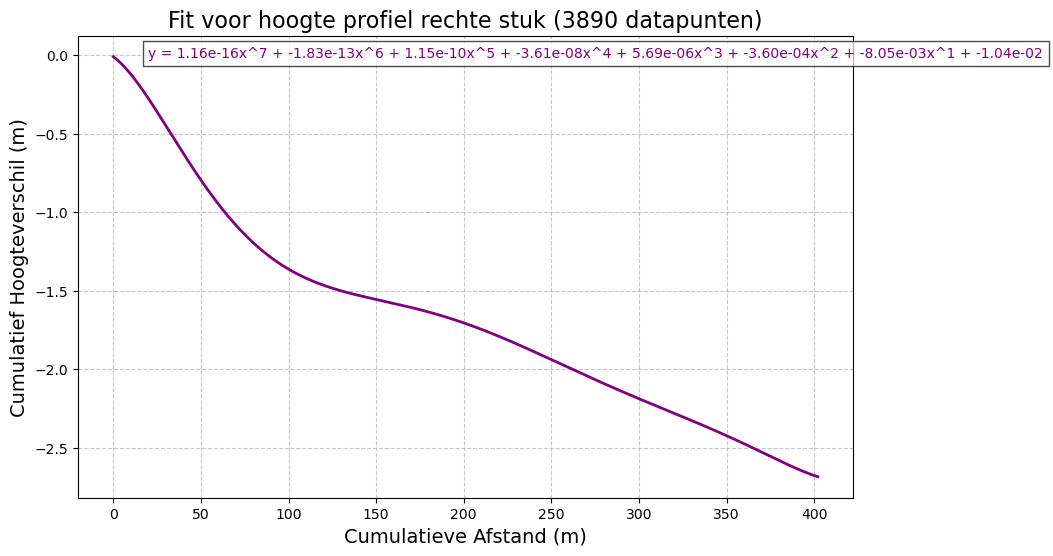

In [18]:
# Dictionary to store datasets for each segment
#formule voor h, pas x_fit aan om het aantal datapunten te veranderen
x_fit = np.linspace(0, 402, 6305)
h = polynomial_7(x_fit)

# Plot the fit equation from x = 0 to x = 275
plt.figure(figsize=(10, 6))
plt.plot(x_fit, h, color='purple', linestyle='-', linewidth=2, label=f'Polynoom fit (graad {degree})')
plt.grid(visible=True, linestyle='--', alpha=0.7)
#Add fit equation to the plot
plt.text(
    0.05 * max(x_fit),
    0.85 * max(y_fit_7),
    fit_equation_7,
    color='purple',
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.7)
)
plt.xlabel('Cumulatieve Afstand (m)', fontsize=14)
plt.ylabel('Cumulatief Hoogteverschil (m)', fontsize=14)
plt.title('Fit voor hoogte profiel rechte stuk (3890 datapunten)', fontsize=16)

plt.show() 

df_h = pd.DataFrame({'hoogteverschil (m)': h})
# Voeg een kolom toe met het verschil in hoogte (delta h)
df_h['delta h (m)'] = df_h['hoogteverschil (m)'].diff().fillna(0)


In [19]:
print(df_ronde7.loc[388561])

Datalogger port                                                          5
Dataloggertijd, in s                                             5973.7964
Format header (>03|04)                                               03|04
Tijd sinds laatste herstart motordriver (s)                      2332.1548
Spanning over de motor (V)                                           0.848
Stroom door de motor (A)                                            -0.051
Vermogen geleverd aan de motor (W)                                    -0.0
Energie geleverd aan de motor sinds reset (J)                       129044
Spanning aan de ingang van motordriver (V)                          27.362
Stroom door de ingang van motordriver (A)                            -0.01
Vermogen geleverd aan de hele motordriver (W)                         -0.3
Energie geleverd aan de hele motordriver sinds reset (J)            138398
Motordriver temperatuur (C)                                          119.9
Motordriver-bord temperat

In [20]:
print(df_ronde7.loc[394865])

Datalogger port                                                          5
Dataloggertijd, in s                                             6029.1847
Format header (>03|04)                                               03|04
Tijd sinds laatste herstart motordriver (s)                      2387.5337
Spanning over de motor (V)                                           0.018
Stroom door de motor (A)                                            -0.078
Vermogen geleverd aan de motor (W)                                    -0.0
Energie geleverd aan de motor sinds reset (J)                       129044
Spanning aan de ingang van motordriver (V)                          30.269
Stroom door de ingang van motordriver (A)                           -0.039
Vermogen geleverd aan de hele motordriver (W)                         -1.2
Energie geleverd aan de hele motordriver sinds reset (J)            138351
Motordriver temperatuur (C)                                         119.35
Motordriver-bord temperat

In [21]:
df_h*-1

,hoogteverschil (m),delta h (m)
0,0.010444,-0.000000
1,0.010959,0.000515
2,0.011477,0.000518
3,0.011998,0.000521
4,0.012521,0.000524
...,...,...
6300,2.684239,0.000227
6301,2.684466,0.000227
6302,2.684692,0.000226
6303,2.684918,0.000225


In [22]:
import pandas as pd

# Berekenen zwaartekracht
massa = 90  # Mass in kg
g = 9.81  # Gravitational acceleration in m/s²

# Initial speed in m/s
begin_snelheid = df_ronde7.loc[388561, "Wielsnelheid, in m/s"]
begin_snelheid_GPS = df_ronde7.loc[394865, "GPS speed, in m/s"]
print(f"Initial speed: {begin_snelheid} m/s")
print(f"Initial speed: {begin_snelheid_GPS} m/s")
# Bereken de initiële kinetische energie
initiele_kinetische_energie = 0.5 * massa * begin_snelheid**2
print(f"Initiële kinetische energie: {initiele_kinetische_energie} J")

initiele_kinetische_energie_GPS = 0.5 * massa * begin_snelheid_GPS**2
print(f"Initiële kinetische energie: {initiele_kinetische_energie_GPS} J")
# 
# Maak een nieuwe lege DataFrame df_e met dezelfde index als df_h
df_e = pd.DataFrame(index=df_h.index)

# Bereken potentiële energie per punt op basis van de hoogteverschillen (neem absolute waarde van delta h)
initiele_potentiële_energie = massa * g * (df_h['hoogteverschil (m)'].iloc[0] - df_h['hoogteverschil (m)'].iloc[6304])
print(f"Initiële potentiële energie: {initiele_potentiële_energie} J")

df_e['Absolute Potentiële Energie verlies(J)'] = massa * g * df_h['delta h (m)'].abs()

# Bereken de omzetting van potentiële energie naar kinetische energie
df_e['Omzetting naar Kinetische Energie (J)'] = df_e['Absolute Potentiële Energie verlies(J)']
df_e['Omzetting naar Potentiële Energie (J)'] = df_e['Absolute Potentiële Energie verlies(J)']

# Bereken de cumulatieve som van de omzetting naar kinetische energie
df_e['Kinetische Energie Totaal (J)'] = df_e['Omzetting naar Kinetische Energie (J)'].cumsum()
df_e['Kinetische Energie Totaal met GPS snelheid (J)'] = df_e['Omzetting naar Kinetische Energie (J)'].cumsum()
# Voeg de initiële kinetische energie toe aan de hele kolom
df_e['Kinetische Energie Totaal (J)'] += initiele_kinetische_energie
df_e['Kinetische Energie Totaal met GPS snelheid (J)'] += initiele_kinetische_energie_GPS

# Bereken de totale potentiële energie en voeg de initiële potentiële energie toe
df_e['Potentiële Energie Totaal (J)'] = df_e['Omzetting naar Potentiële Energie (J)'][::-1].cumsum()[::-1]
df_e['Potentiële Energie Totaal (J)'] += initiele_potentiële_energie

# Bereken de totale energie
df_e['Totale Energie (J)'] = df_e['Potentiële Energie Totaal (J)'] + df_e['Kinetische Energie Totaal (J)']
df_e['Totale Energie met GPS snelheid (J)'] = df_e['Potentiële Energie Totaal (J)'] + df_e['Kinetische Energie Totaal met GPS snelheid (J)']

totale_energie_GPS = df_e['Totale Energie met GPS snelheid (J)'].values
totale_energie = df_e['Totale Energie (J)'].values

array_potentieel = df_e['Potentiële Energie Totaal (J)'].values
# Sla de potentiële energie op in een variabele voor gebruik in de tweede cel
potentiele_energie_uit_df_e = array_potentieel
print(potentiele_energie_uit_df_e)
# Print het resultaat voor controle
df_e


Initial speed: 6.819722222222222 m/s
Initial speed: 6.833333333333334 m/s
Initiële kinetische energie: 2092.887503472222 J
Initiële kinetische energie: 2101.2500000000005 J
Initiële potentiële energie: 2361.4912600035286 J
[4722.98252001 4722.98252001 4722.5278224  ... 2362.08841876 2361.88878187
 2361.68972821]


,Absolute Potentiële Energie verlies(J),Omzetting naar Kinetische Energie (J),Omzetting naar Potentiële Energie (J),Kinetische Energie Totaal (J),Kinetische Energie Totaal met GPS snelheid (J),Potentiële Energie Totaal (J),Totale Energie (J),Totale Energie met GPS snelheid (J)
0,0.000000,0.000000,0.000000,2092.887503,2101.250000,4722.982520,6815.870023,6824.232520
1,0.454698,0.454698,0.454698,2093.342201,2101.704698,4722.982520,6816.324721,6824.687218
2,0.457277,0.457277,0.457277,2093.799478,2102.161975,4722.527822,6816.327301,6824.689797
3,0.459849,0.459849,0.459849,2094.259327,2102.621824,4722.070545,6816.329872,6824.692369
4,0.462413,0.462413,0.462413,2094.721740,2103.084237,4721.610696,6816.332436,6824.694933
...,...,...,...,...,...,...,...,...
6300,0.200797,0.200797,0.200797,4453.581387,4461.943883,2362.489433,6816.070820,6824.433317
6301,0.200218,0.200218,0.200218,4453.781605,4462.144101,2362.288637,6816.070241,6824.432738
6302,0.199637,0.199637,0.199637,4453.981242,4462.343738,2362.088419,6816.069660,6824.432157
6303,0.199054,0.199054,0.199054,4454.180295,4462.542792,2361.888782,6816.069077,6824.431574


In [23]:
start_index = 388561
end_index = start_index + 6304

# Bereken de kinetische energie met de gemeten snelheden van df_ronde6
gemeten_snelheden = df_ronde7.loc[start_index:end_index, "Wielsnelheid, in m/s"]
df_e_kin = pd.DataFrame(index=gemeten_snelheden.index)  # Nieuwe DataFrame voor de gemeten kinetische energie
df_e_kin["Afgelegde afstand (m)"] = df_ronde7.loc[start_index:end_index, "Afgelegde afstand sinds laatste herstart motordriver (m)"]
df_e_kin['Gemeten_snelheden_GPS (m/s)'] = df_ronde7.loc[start_index:end_index, "GPS speed, in m/s"]
df_e_kin['Gemeten Snelheid (m/s)'] = gemeten_snelheden
df_e_kin['Kinetische Energie (J)'] = 0.5 * massa * df_e_kin['Gemeten Snelheid (m/s)']**2
df_e_kin['Kinetische Energie met GPS snelheid (J)'] = 0.5 * massa * df_e_kin['Gemeten_snelheden_GPS (m/s)']**2
# Zorg dat de potentiële energie wordt gesynchroniseerd met df_e


# Vul eventuele NaN-waarden op

# Voeg de potentiële energie toe aan df_e_kin
df_e_kin['Potentiële Energie Totaal (J)'] = potentiele_energie_uit_df_e

# Bereken de totale energie
df_e_kin['Totale Energie (J)'] = df_e_kin['Potentiële Energie Totaal (J)'] + df_e_kin['Kinetische Energie (J)']

df_e_kin['Totale Energie met GPS snelheid (J)'] = df_e_kin['Potentiële Energie Totaal (J)'] + df_e_kin['Kinetische Energie met GPS snelheid (J)']
# Controleer de DataFrame op NaN-waarden
if df_e_kin.isna().any().any():
    print("Waarschuwing: Er zijn nog NaN-waarden in df_e_kin!")
    
df_e_kin["Totale theoretische Energie met GPS snelheid (J)"] = totale_energie_GPS
df_e_kin["Energie vershil met GPS snelheid (J)"] = df_e_kin["Totale theoretische Energie met GPS snelheid (J)"] - df_e_kin["Totale Energie met GPS snelheid (J)"]

df_e_kin["Totale theoretische energie (J)"] = totale_energie
df_e_kin["Energie vershil (J)"] = df_e_kin["Totale theoretische energie (J)"] - df_e_kin["Totale Energie (J)"]

df_e_kin["delta energie met GPS snelheid (J)"] = df_e_kin["Energie vershil met GPS snelheid (J)"].diff()
df_e_kin["delta afstand"] = df_e_kin["Afgelegde afstand (m)"].diff()
df_e_kin["delta energie (J)"] = df_e_kin["Energie vershil (J)"].diff()

df_e_kin['Weerstand met GPS Snelheid (N)'] = df_e_kin["delta energie met GPS snelheid (J)"] / df_e_kin["delta afstand"]
df_e_kin['Weerstand (N)'] = df_e_kin["delta energie met GPS snelheid (J)"] / df_e_kin["delta afstand"]
# Print het resultaat voor controle
df_e_kin


,Afgelegde afstand (m),Gemeten_snelheden_GPS (m/s),Gemeten Snelheid (m/s),Kinetische Energie (J),Kinetische Energie met GPS snelheid (J),Potentiële Energie Totaal (J),Totale Energie (J),Totale Energie met GPS snelheid (J),Totale theoretische Energie met GPS snelheid (J),Energie vershil met GPS snelheid (J),Totale theoretische energie (J),Energie vershil (J),delta energie met GPS snelheid (J),delta afstand,delta energie (J),Weerstand met GPS Snelheid (N),Weerstand (N)
388561,10512.16,6.750000,6.819722,2092.887503,2050.312500,4722.982520,6815.870023,6773.295020,6824.232520,50.937500,6815.870023,0.000000,NaN,NaN,NaN,NaN,NaN
388562,10512.22,6.750000,6.845278,2108.602253,2050.312500,4722.982520,6831.584773,6773.295020,6824.687218,51.392198,6816.324721,-15.260052,0.454698,0.06,-15.260052,7.578293,7.578293
388563,10512.29,6.777778,6.840833,2105.865031,2067.222222,4722.527822,6828.392854,6789.750045,6824.689797,34.939753,6816.327301,-12.065553,-16.452445,0.07,3.194499,-235.034929,-235.034929
388564,10512.35,6.777778,6.848056,2110.313920,2067.222222,4722.070545,6832.384465,6789.292767,6824.692369,35.399602,6816.329872,-16.054593,0.459849,0.06,-3.989040,7.664150,7.664150
388565,10512.41,6.777778,6.861944,2118.882670,2067.222222,4721.610696,6840.493366,6788.832918,6824.694933,35.862015,6816.332436,-24.160930,0.462413,0.06,-8.106337,7.706883,7.706883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394861,10914.48,6.833333,6.776944,2066.713920,2101.250000,2362.489433,4429.203353,4463.739433,6824.433317,2360.693883,6816.070820,2386.867467,0.200797,0.12,114.577047,1.673306,1.673306
394862,10914.48,6.833333,6.955000,2176.741125,2101.250000,2362.288637,4539.029762,4463.538637,6824.432738,2360.894101,6816.070241,2277.040480,0.200218,0.00,-109.826987,inf,inf
394863,10914.60,6.833333,6.768889,2061.803556,2101.250000,2362.088419,4423.891974,4463.338419,6824.432157,2361.093738,6816.069660,2392.177686,0.199637,0.12,115.137206,1.663641,1.663641
394864,10914.60,6.833333,6.943611,2169.618087,2101.250000,2361.888782,4531.506869,4463.138782,6824.431574,2361.292792,6816.069077,2284.562208,0.199054,0.00,-107.615478,inf,inf


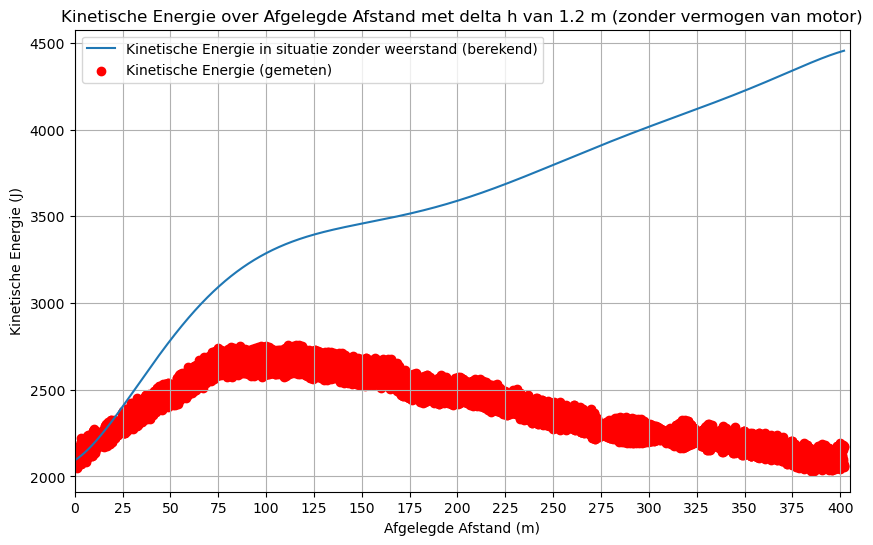

In [24]:
# Plot de kinetische energie tegen de afgelegde afstand
x= np.linspace(0,402,6305)
plt.figure(figsize=(10, 6))
plt.plot(x, df_e['Kinetische Energie Totaal (J)'], label='Kinetische Energie in situatie zonder weerstand (berekend)')
plt.scatter(x, df_e_kin['Kinetische Energie (J)'], label='Kinetische Energie (gemeten)', color = 'r')


# Labels en titel toevoegen
plt.xlim(0,405)
plt.xticks(np.arange(0, 405, 25))  # Stel de x-as in stappen van 25
plt.xlabel('Afgelegde Afstand (m)')
plt.ylabel('Kinetische Energie (J)')
plt.title('Kinetische Energie over Afgelegde Afstand met delta h van 1.2 m (zonder vermogen van motor)')
plt.legend()
plt.grid(True)

# Toon de grafiek
plt.show()

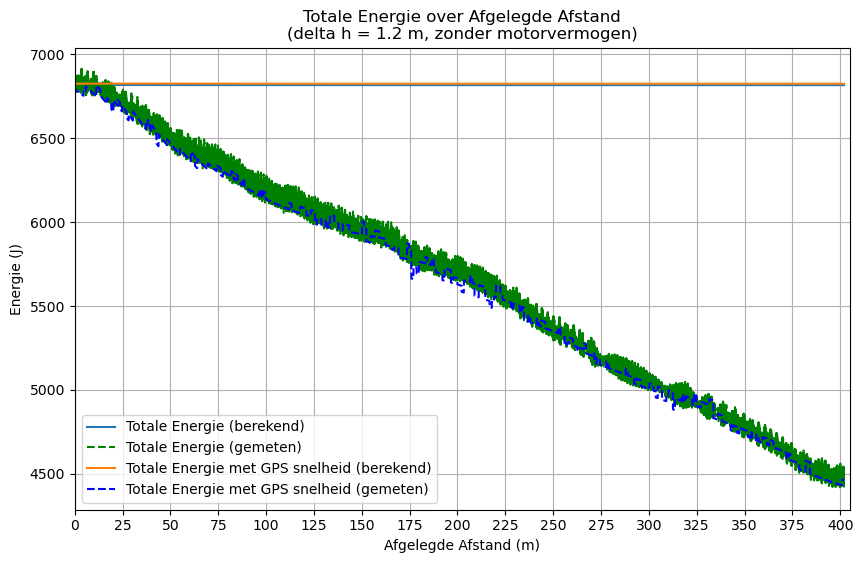

In [25]:
# Genereer de x-as op basis van de afgelegde afstand
x = np.linspace(0, 402, 6305)

# Maak de plot
plt.figure(figsize=(10, 6))

# Plot de kinetische energie (berekend en gemeten)
plt.plot(x, df_e['Totale Energie (J)'], label='Totale Energie (berekend)')
#plt.scatter(x, df_e_kin['Kinetische Energie (J)'], label='Kinetische Energie (gemeten)', color='r')

# Plot de totale energie
plt.plot(x, df_e_kin['Totale Energie (J)'], label='Totale Energie (gemeten)', color='g', linestyle='--')

plt.plot(x, df_e['Totale Energie met GPS snelheid (J)'], label='Totale Energie met GPS snelheid (berekend)')
#plt.scatter(x, df_e_kin['Kinetische Energie (J)'], label='Kinetische Energie (gemeten)', color='r')

# Plot de totale energie
plt.plot(x, df_e_kin['Totale Energie met GPS snelheid (J)'], label='Totale Energie met GPS snelheid (gemeten)', color='b', linestyle='--')
# Labels en titel toevoegen
plt.xlim(0, 405)
plt.xticks(np.arange(0, 405, 25))  # Stel de x-as in stappen van 25
plt.xlabel('Afgelegde Afstand (m)')
plt.ylabel('Energie (J)')
plt.title('Totale Energie over Afgelegde Afstand\n(delta h = 1.2 m, zonder motorvermogen)')
plt.legend()
plt.grid(True)

# Toon de grafiek
plt.show()


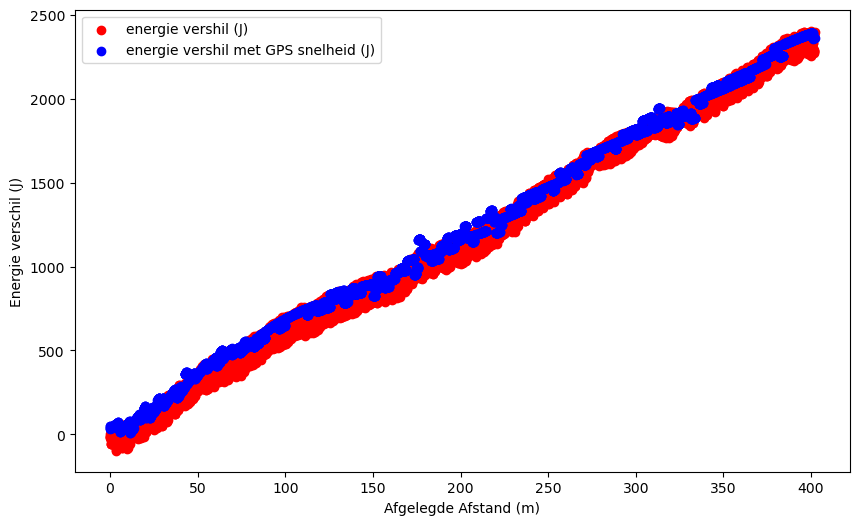

In [26]:
plt.figure(figsize=(10, 6))

plt.scatter(x,df_e_kin["Energie vershil (J)"], label='energie vershil (J)', color = 'r')
plt.scatter(x,df_e_kin["Energie vershil met GPS snelheid (J)"], label='energie vershil met GPS snelheid (J)', color = 'b')
plt.xlabel('Afgelegde Afstand (m)')
plt.ylabel('Energie verschil (J)')
plt.legend()
plt.show()


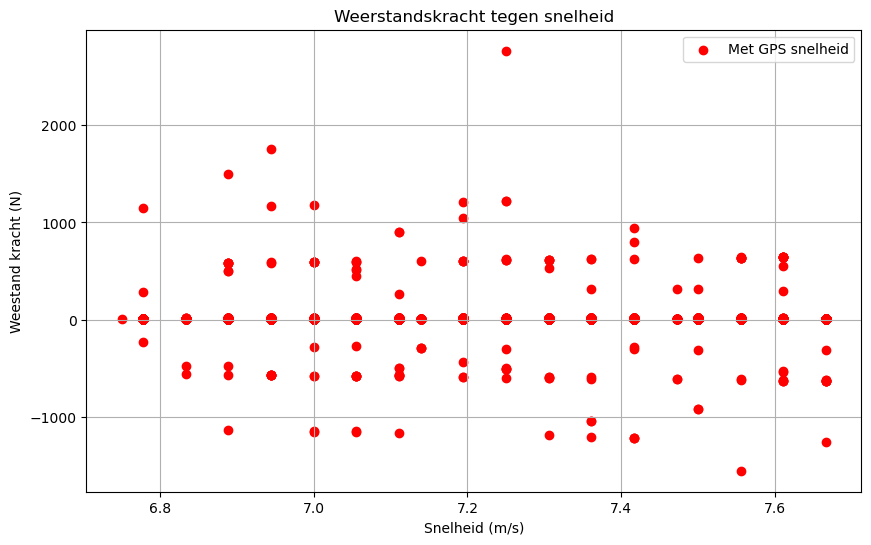

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(df_e_kin["Gemeten_snelheden_GPS (m/s)"],df_e_kin['Weerstand met GPS Snelheid (N)'], label='Met GPS snelheid', color = 'r')
#plt.scatter(df_e_kin["Gemeten Snelheid (m/s)"],df_e_kin['Weerstand (N)'], label='Met wielsnelheid', color = 'b')

plt.title('Weerstandskracht tegen snelheid')
plt.xlabel('Snelheid (m/s)')
plt.ylabel('Weestand kracht (N)')
plt.legend()
plt.grid()
plt.show()

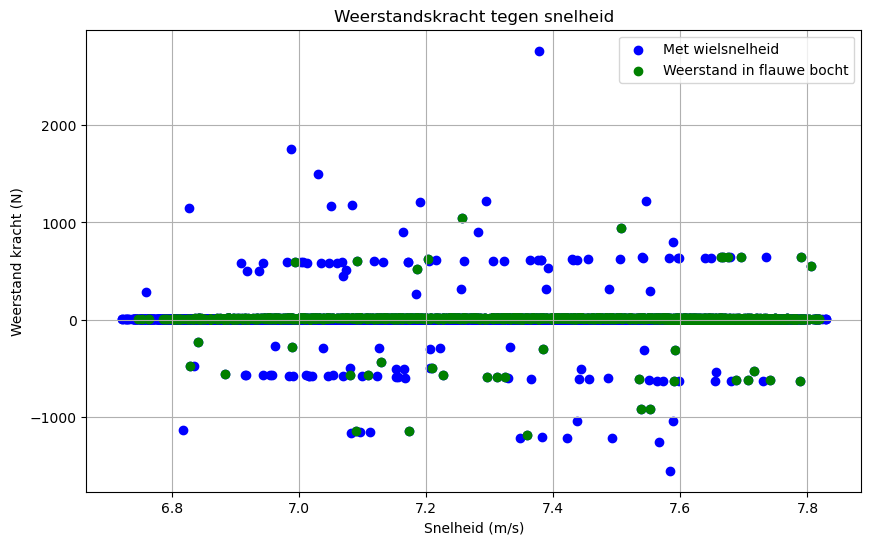

In [28]:
import matplotlib.pyplot as plt

# Eerst, laten we de data voor de specifieke index range voorbereiden
specifieke_indices = df_e_kin.loc[388561:390300]

plt.figure(figsize=(10, 6))

# Teken alle punten
plt.scatter(df_e_kin["Gemeten Snelheid (m/s)"], df_e_kin['Weerstand (N)'],
            label='Met wielsnelheid', color='b')

# Teken nu de specifieke punten in het groen
plt.scatter(specifieke_indices["Gemeten Snelheid (m/s)"], specifieke_indices['Weerstand (N)'],
            color='green', label='Weerstand in flauwe bocht')

plt.title('Weerstandskracht tegen snelheid')
plt.xlabel('Snelheid (m/s)')
plt.ylabel('Weerstand kracht (N)')
plt.legend()
plt.grid()
plt.show()


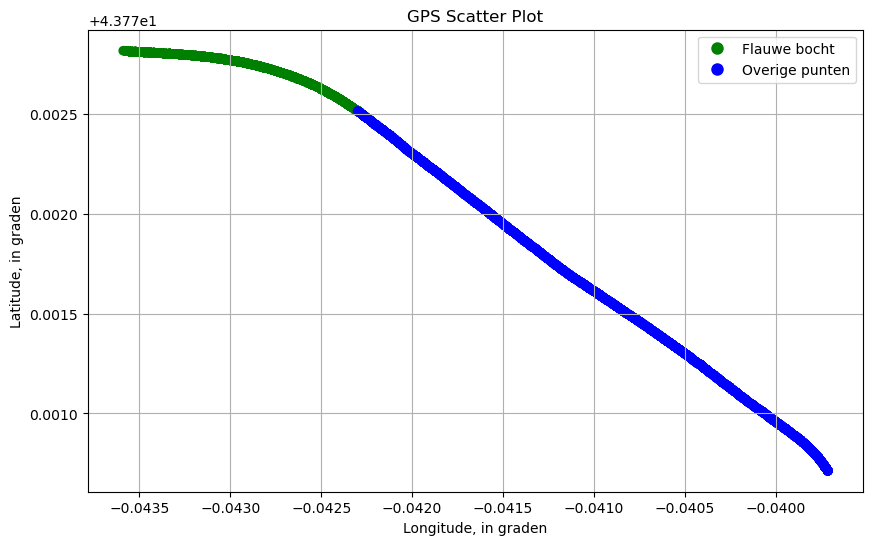

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Stel de DataFrame opnieuw samen voor het rechte stuk
rechte_stuk_ronde7 = filtered_motordriver.loc[388561:394865]

# Bereid een kleurenarray voor alle punten, standaard ingesteld op blauw
colors = ['blue'] * len(rechte_stuk_ronde7)

# Vind de indices van de specifieke punten en zet de kleur naar groen
special_indices = [388561, 390300]
index_positions = [rechte_stuk_ronde7.index.get_loc(idx) for idx in special_indices if idx in rechte_stuk_ronde7.index]

# Als beide indices gevonden zijn, kleur alle punten tussen deze indices groen
if len(index_positions) == 2:
    start_pos, end_pos = sorted(index_positions)  # Zorg ervoor dat start_pos < end_pos
    for i in range(start_pos, end_pos + 1):
        colors[i] = 'green'

# Maak de scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    rechte_stuk_ronde7['GPS longitude, in graden'],
    rechte_stuk_ronde7['GPS latitude, in graden'],
    color=colors,
    label='GPS Data Points'
)

# Extra's toevoegen
plt.title('GPS Scatter Plot')
plt.xlabel('Longitude, in graden')
plt.ylabel('Latitude, in graden')
plt.grid(True)

# Legenda toevoegen
green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Flauwe bocht')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Overige punten')
plt.legend(handles=[green_patch, blue_patch])

# Toon de plot
plt.show()


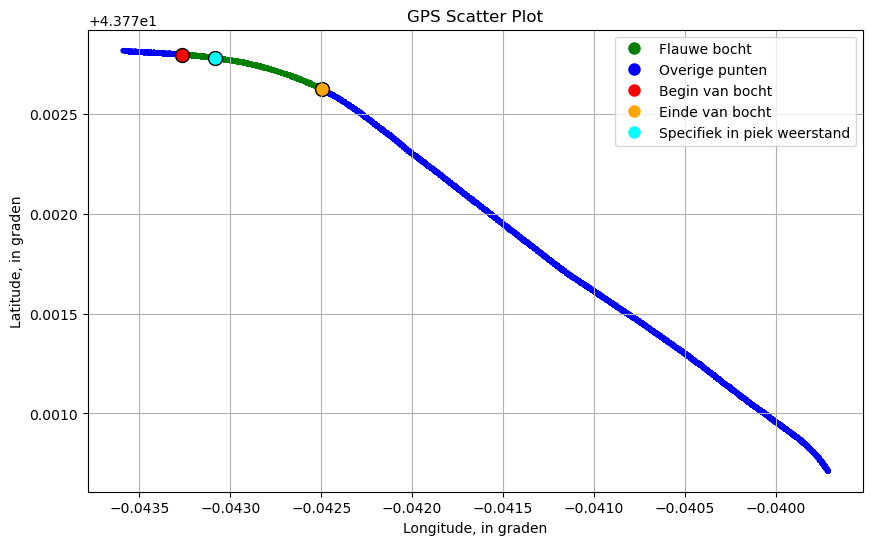

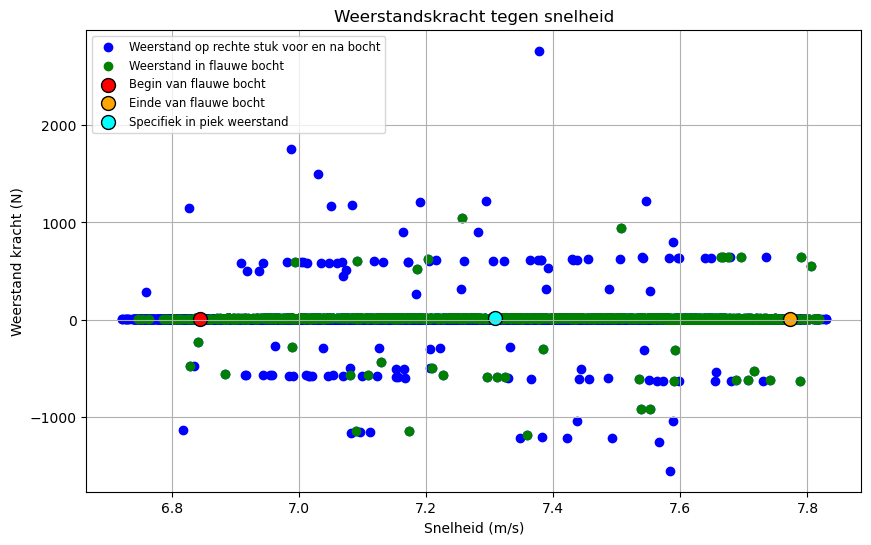

In [30]:
import matplotlib.pyplot as plt
#Met wielsnelheid

# Eerst, laten we de data voor de specifieke index range voorbereiden
specifieke_indices = df_e_kin.loc[388561:390200]

plt.figure(figsize=(10, 6))

# Teken alle punten in blauw
plt.scatter(df_e_kin["Gemeten Snelheid (m/s)"], df_e_kin['Weerstand (N)'],
            label='Weerstand op rechte stuk voor en na bocht', color='b')

# Teken nu de specifieke punten in het groen
plt.scatter(specifieke_indices["Gemeten Snelheid (m/s)"], specifieke_indices['Weerstand (N)'],
            color='green', label='Weerstand in flauwe bocht')

# Markeer het beginpunt met rood
plt.scatter(df_e_kin.loc[388562, "Gemeten Snelheid (m/s)"], df_e_kin.loc[388562, 'Weerstand (N)'],
            color='red', label='Begin van flauwe bocht', s=100, edgecolor='black')

# Markeer het eindpunt met oranje
plt.scatter(df_e_kin.loc[390200, "Gemeten Snelheid (m/s)"], df_e_kin.loc[390200, 'Weerstand (N)'],
            color='orange', label='Einde van flauwe bocht', s=100, edgecolor='black')

# Markeer een ander specifiek punt met cyan
plt.scatter(df_e_kin.loc[389221, "Gemeten Snelheid (m/s)"], df_e_kin.loc[389221, 'Weerstand (N)'],
            color='cyan', label='Specifiek in piek weerstand', s=100, edgecolor='black')

plt.title('Weerstandskracht tegen snelheid')
plt.xlabel('Snelheid (m/s)')
plt.ylabel('Weerstand kracht (N)')
plt.grid(True)

# We passen de legenda aan zodat elk label maar één keer verschijnt
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Verwijder duplicaten

# Pas de legenda aan: kleinere lettergrootte en plaatsing linksboven
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize='small')

plt.show()


Animation saved as dynamic_tracking_single_color.html.


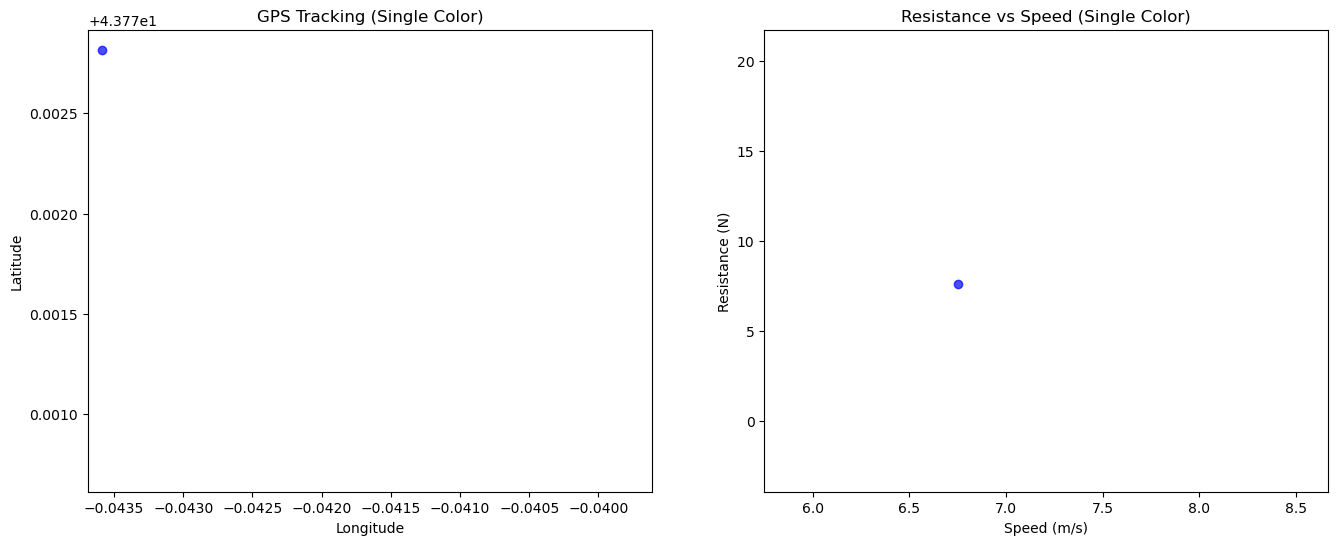

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, HTMLWriter
import pandas as pd

# Assuming 'df_e_kin' and 'filtered_motordriver' are your dataframes and correctly loaded with data

# Convert speeds to m/s
df_e_kin['Speed_m/s'] = df_e_kin['Gemeten_snelheden_GPS (m/s)']

# Remove rows where acceleration, speed, or resistance is NaN or infinite
df_e_kin = df_e_kin.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
df_e_kin = df_e_kin.dropna(subset=['Speed_m/s', 'Weerstand (N)'])  # Drop rows with NaN in these columns

# Filter data for resistance between 0 and 20 N
df_e_kin = df_e_kin[(df_e_kin['Weerstand (N)'] >= 0) & (df_e_kin['Weerstand (N)'] <= 20)]

# Prepare the figure for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Setup for GPS data plot
ax1.set_xlim(rechte_stuk_ronde7['GPS longitude, in graden'].min() - 0.0001, rechte_stuk_ronde7['GPS longitude, in graden'].max() + 0.0001)
ax1.set_ylim(rechte_stuk_ronde7['GPS latitude, in graden'].min() - 0.0001, rechte_stuk_ronde7['GPS latitude, in graden'].max() + 0.0001)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("GPS Tracking (Single Color)")

# Setup for resistance vs speed plot
ax2.set_xlim(df_e_kin['Speed_m/s'].min() - 1, df_e_kin['Speed_m/s'].max() + 1)
ax2.set_ylim(df_e_kin['Weerstand (N)'].min() - 5, df_e_kin['Weerstand (N)'].max() + 5)
ax2.set_xlabel("Speed (m/s)")
ax2.set_ylabel("Resistance (N)")
ax2.set_title("Resistance vs Speed (Single Color)")

# Initialize scatter plots
scat1 = ax1.scatter([], [], color='blue', alpha=0.7)
scat2 = ax2.scatter([], [], color='blue', alpha=0.7)

# Add a legend for acceleration categories
legend_labels = [
    ('red', 'Voor bocht'),
    ('blue', 'In bocht'),
    ('yellow', 'Na bocht')
]
for color, label in legend_labels:
    ax2.scatter([], [], color=color, label=label)  # Dummy points for legend
ax2.legend(title="Kleurenlegenda", loc='upper left')

# Define the update function for the animation
def update(frame):
    end = frame + 1  # Display one additional row per frame
    if end > len(df_e_kin):  # Stop when all data is shown
        return

    # Extract data chunk
    chunk = df_e_kin.iloc[:end]  # Include all data up to the current frame

    colors = chunk.index.map(
    lambda i: 'red' if i < 389106 else ('blue' if i <= 390200 else 'yellow'))
    
    # Update the GPS plot
    chunk_lat = rechte_stuk_ronde7.iloc[:end]['GPS latitude, in graden']
    chunk_lon = rechte_stuk_ronde7.iloc[:end]['GPS longitude, in graden']
    scat1.set_offsets(np.column_stack((chunk_lon, chunk_lat)))
    
    # Update the resistance vs speed plot
    scat2.set_offsets(np.column_stack((chunk['Speed_m/s'], chunk['Weerstand (N)'])))

# Animation settings
frames_count = max(len(rechte_stuk_ronde7), len(df_e_kin))
anim = FuncAnimation(fig, update, frames=frames_count, repeat=False, interval=100)  # Adjust the interval as needed

# Save as HTML file
output_path = "dynamic_tracking_single_color.html"
html_writer = HTMLWriter()
anim.save(output_path, writer=html_writer)

print(f"Animation saved as {output_path}.")


Animatie opgeslagen als dynamic_tracking_single_color_bocht.html.


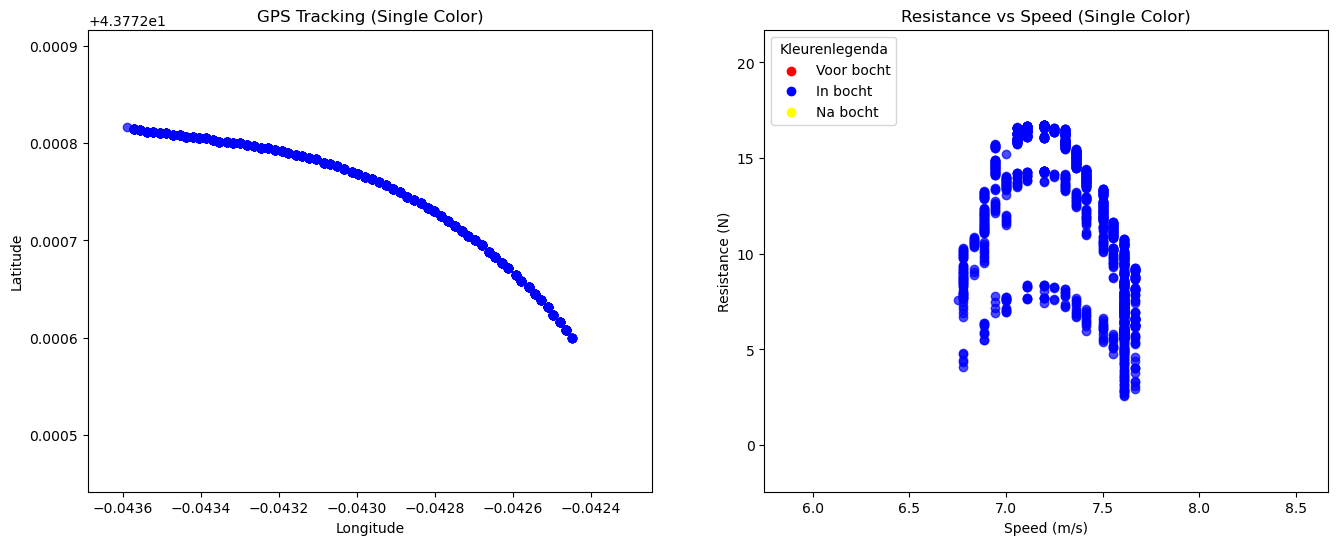

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, HTMLWriter
import pandas as pd

# Veronderstel dat 'df_e_kin' en 'rechte_stuk_ronde7' correct zijn geladen met de benodigde data

# Filter de dataframes op de gewenste indexrange
start_index = 388561
end_index = 390200

df_e_kin_filtered = df_e_kin.loc[start_index:end_index].copy()
rechte_stuk_ronde7_filtered = rechte_stuk_ronde7.loc[start_index:end_index].copy()

# Converteer snelheden naar m/s
df_e_kin_filtered['Speed_m/s'] = df_e_kin_filtered['Gemeten_snelheden_GPS (m/s)']

# Verwijder rijen waar snelheid of weerstand NaN of oneindig is
df_e_kin_filtered = df_e_kin_filtered.replace([np.inf, -np.inf], np.nan)
df_e_kin_filtered = df_e_kin_filtered.dropna(subset=['Speed_m/s', 'Weerstand (N)'])

# Filter data voor weerstand tussen 0 en 20 N
df_e_kin_filtered = df_e_kin_filtered[(df_e_kin_filtered['Weerstand (N)'] >= 0) & (df_e_kin_filtered['Weerstand (N)'] <= 20)]

# Bereid de figuur voor om te plotten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Instellingen voor GPS-gegevensplot
ax1.set_xlim(rechte_stuk_ronde7_filtered['GPS longitude, in graden'].min() - 0.0001,
             rechte_stuk_ronde7_filtered['GPS longitude, in graden'].max() + 0.0001)
ax1.set_ylim(rechte_stuk_ronde7_filtered['GPS latitude, in graden'].min() - 0.0001,
             rechte_stuk_ronde7_filtered['GPS latitude, in graden'].max() + 0.0001)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("GPS Tracking (Single Color)")

# Instellingen voor weerstand versus snelheid plot
ax2.set_xlim(df_e_kin_filtered['Speed_m/s'].min() - 1, df_e_kin_filtered['Speed_m/s'].max() + 1)
ax2.set_ylim(df_e_kin_filtered['Weerstand (N)'].min() - 5, df_e_kin_filtered['Weerstand (N)'].max() + 5)
ax2.set_xlabel("Speed (m/s)")
ax2.set_ylabel("Resistance (N)")
ax2.set_title("Resistance vs Speed (Single Color)")

# Initialiseer scatter plots met lege numpy-arrays
scat1 = ax1.scatter([], [], color='blue', alpha=0.7, animated=True)
scat2 = ax2.scatter([], [], color='blue', alpha=0.7, animated=True)

# Voeg een legenda toe voor acceleratiecategorieën
legend_labels = [
    ('red', 'Voor bocht'),
    ('blue', 'In bocht'),
    ('yellow', 'Na bocht')
]
for color, label in legend_labels:
    ax2.scatter([], [], color=color, label=label)  # Dummy punten voor legenda
ax2.legend(title="Kleurenlegenda", loc='upper left')

# Definieer de initialisatiefunctie voor de animatie
def init():
    scat1.set_offsets(np.empty((0, 2)))
    scat2.set_offsets(np.empty((0, 2)))
    return scat1, scat2

# Definieer de updatefunctie voor de animatie
def update(frame):
    end = frame + 1  # Toon één extra rij per frame
    if end > len(df_e_kin_filtered):  # Stop wanneer alle data is weergegeven
        return scat1, scat2

    # Haal data op tot het huidige frame
    chunk = df_e_kin_filtered.iloc[:end]

    # Update de GPS-plot
    chunk_lat = rechte_stuk_ronde7_filtered.iloc[:end]['GPS latitude, in graden']
    chunk_lon = rechte_stuk_ronde7_filtered.iloc[:end]['GPS longitude, in graden']
    scat1.set_offsets(np.column_stack((chunk_lon, chunk_lat)))

    # Update de weerstand versus snelheid plot
    scat2.set_offsets(np.column_stack((chunk['Speed_m/s'], chunk['Weerstand (N)'])))

    return scat1, scat2

# Animatie-instellingen
frames_count = len(df_e_kin_filtered)
anim = FuncAnimation(fig, update, frames=frames_count, init_func=init, repeat=False, interval=50, blit=True)

# Sla op als MP4-bestand
output_path = "dynamic_tracking_single_color_bocht.html"
html_writer = HTMLWriter()
anim.save(output_path, writer=html_writer, dpi=80)

print(f"Animatie opgeslagen als {output_path}.")


In [31]:
# Voeg de kolommen van df_e_kin_filtered toe aan rechte_stuk_ronde7_filtered
df_combined = pd.concat([rechte_stuk_ronde7, df_e_kin], axis=1)

# Bekijk het gecombineerde dataframe
df_combined

,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,Totale Energie met GPS snelheid (J),Totale theoretische Energie met GPS snelheid (J),Energie vershil met GPS snelheid (J),Totale theoretische energie (J),Energie vershil (J),delta energie met GPS snelheid (J),delta afstand,delta energie (J),Weerstand met GPS Snelheid (N),Weerstand (N)
388561,5,5973.7964,03|04,2332.1548,0.848,-0.051,-0.0,129044,27.362,-0.010,...,6773.295020,6824.232520,50.937500,6815.870023,0.000000,NaN,NaN,NaN,NaN,NaN
388562,5,5973.8052,03|04,2332.1636,0.830,-0.049,-0.0,129044,27.363,-0.009,...,6773.295020,6824.687218,51.392198,6816.324721,-15.260052,0.454698,0.06,-15.260052,7.578293,7.578293
388563,5,5973.8140,03|04,2332.1724,0.812,-0.051,-0.0,129044,27.364,-0.014,...,6789.750045,6824.689797,34.939753,6816.327301,-12.065553,-16.452445,0.07,3.194499,-235.034929,-235.034929
388564,5,5973.8228,03|04,2332.1812,0.797,-0.051,-0.0,129044,27.366,-0.009,...,6789.292767,6824.692369,35.399602,6816.329872,-16.054593,0.459849,0.06,-3.989040,7.664150,7.664150
388565,5,5973.8315,03|04,2332.1899,0.783,-0.050,-0.0,129044,27.368,-0.006,...,6788.832918,6824.694933,35.862015,6816.332436,-24.160930,0.462413,0.06,-8.106337,7.706883,7.706883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394861,5,6029.1495,03|04,2387.4983,0.021,-0.079,-0.0,129044,30.269,-0.042,...,4463.739433,6824.433317,2360.693883,6816.070820,2386.867467,0.200797,0.12,114.577047,1.673306,1.673306
394862,5,6029.1583,03|04,2387.5071,0.020,-0.078,-0.0,129044,30.269,-0.042,...,4463.538637,6824.432738,2360.894101,6816.070241,2277.040480,0.200218,0.00,-109.826987,inf,inf
394863,5,6029.1671,03|04,2387.5161,0.019,-0.078,-0.0,129044,30.269,-0.044,...,4463.338419,6824.432157,2361.093738,6816.069660,2392.177686,0.199637,0.12,115.137206,1.663641,1.663641
394864,5,6029.1759,03|04,2387.5249,0.019,-0.078,-0.0,129044,30.269,-0.039,...,4463.138782,6824.431574,2361.292792,6816.069077,2284.562208,0.199054,0.00,-107.615478,inf,inf


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, HTMLWriter
import pandas as pd

# Assuming 'df_e_kin' and 'filtered_motordriver' are your dataframes and correctly loaded with data

# Convert speeds to m/s
df_e_kin['Speed_m/s'] = df_e_kin['Gemeten_snelheden_GPS (m/s)']

# Remove rows where acceleration, speed, or resistance is NaN or infinite
df_e_kin = df_e_kin.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
df_e_kin = df_e_kin.dropna(subset=['Speed_m/s', 'Weerstand (N)'])  # Drop rows with NaN in these columns

# Filter data for resistance between 0 and 20 N
df_e_kin = df_e_kin[(df_e_kin['Weerstand (N)'] >= 0) & (df_e_kin['Weerstand (N)'] <= 20)]

# Prepare the figure for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Setup for GPS data plot
ax1.set_xlim(rechte_stuk_ronde7['GPS longitude, in graden'].min() - 0.0001, rechte_stuk_ronde7['GPS longitude, in graden'].max() + 0.0001)
ax1.set_ylim(rechte_stuk_ronde7['GPS latitude, in graden'].min() - 0.0001, rechte_stuk_ronde7['GPS latitude, in graden'].max() + 0.0001)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("GPS Tracking (Single Color)")

# Setup for resistance vs speed plot
ax2.set_xlim(df_e_kin['Speed_m/s'].min() - 1, df_e_kin['Speed_m/s'].max() + 1)
ax2.set_ylim(df_e_kin['Weerstand (N)'].min() - 5, df_e_kin['Weerstand (N)'].max() + 5)
ax2.set_xlabel("Speed (m/s)")
ax2.set_ylabel("Resistance (N)")
ax2.set_title("Resistance vs Speed (Single Color)")

# Initialize scatter plots
scat1 = ax1.scatter([], [], color='blue', alpha=0.7)
scat2 = ax2.scatter([], [], color='blue', alpha=0.7)

# Add a legend for acceleration categories
legend_labels = [
    ('red', 'Voor bocht'),
    ('blue', 'In bocht'),
    ('yellow', 'Na bocht')
]
for color, label in legend_labels:
    ax2.scatter([], [], color=color, label=label)  # Dummy points for legend
ax2.legend(title="Kleurenlegenda", loc='upper left')

# Define the update function for the animation
def update(frame):
    end = frame + 1  # Display one additional row per frame
    if end > len(df_e_kin):  # Stop when all data is shown
        return

    # Extract data chunk
    chunk = df_e_kin.iloc[:end]  # Include all data up to the current frame

    colors = chunk.index.map(
    lambda i: 'red' if i < 389106 else ('blue' if i <= 390200 else 'yellow'))
    
    # Update the GPS plot
    chunk_lat = rechte_stuk_ronde7.iloc[:end]['GPS latitude, in graden']
    chunk_lon = rechte_stuk_ronde7.iloc[:end]['GPS longitude, in graden']
    scat1.set_offsets(np.column_stack((chunk_lon, chunk_lat)))
    
    # Update the resistance vs speed plot
    scat2.set_offsets(np.column_stack((chunk['Speed_m/s'], chunk['Weerstand (N)'])))

# Animation settings
frames_count = max(len(rechte_stuk_ronde7), len(df_e_kin))
anim = FuncAnimation(fig, update, frames=frames_count, repeat=False, interval=100)  # Adjust the interval as needed

# Save as HTML file
output_path = "dynamic_tracking_single_color.html"
html_writer = HTMLWriter()
anim.save(output_path, writer=html_writer)

print(f"Animation saved as {output_path}.")


,Afgelegde afstand (m),Gemeten_snelheden_GPS (m/s),Gemeten Snelheid (m/s),Kinetische Energie (J),Kinetische Energie met GPS snelheid (J),Potentiële Energie Totaal (J),Totale Energie (J),Totale Energie met GPS snelheid (J),Totale theoretische Energie met GPS snelheid (J),Energie vershil met GPS snelheid (J),Totale theoretische energie (J),Energie vershil (J),delta energie met GPS snelheid (J),delta afstand,delta energie (J),Weerstand met GPS Snelheid (N),Weerstand (N),Speed_m/s
388562,10512.22,6.750000,6.845278,2108.602253,2050.312500,4722.982520,6831.584773,6773.295020,6824.687218,51.392198,6816.324721,-15.260052,0.454698,0.06,-15.260052,7.578293,7.578293,6.750000
388564,10512.35,6.777778,6.848056,2110.313920,2067.222222,4722.070545,6832.384465,6789.292767,6824.692369,35.399602,6816.329872,-16.054593,0.459849,0.06,-3.989040,7.664150,7.664150,6.777778
388565,10512.41,6.777778,6.861944,2118.882670,2067.222222,4721.610696,6840.493366,6788.832918,6824.694933,35.862015,6816.332436,-24.160930,0.462413,0.06,-8.106337,7.706883,7.706883,6.777778
388566,10512.47,6.777778,6.845833,2108.944531,2067.222222,4721.148283,6830.092814,6788.370505,6824.697489,36.326984,6816.334993,-13.757822,0.464969,0.06,10.403108,7.749487,7.749487,6.777778
388567,10512.53,6.777778,6.888611,2135.383337,2067.222222,4720.683314,6856.066651,6787.905536,6824.700038,36.794502,6816.337541,-39.729110,0.467518,0.06,-25.971288,7.791962,7.791962,6.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390196,10618.12,7.611111,7.696667,2665.740500,2606.805556,3505.805464,6171.545964,6112.611020,6824.564093,711.953073,6816.201597,644.655632,0.331573,0.06,25.984410,5.526219,5.526219,7.611111
390197,10618.18,7.611111,7.679444,2653.824014,2606.805556,3505.473891,6159.297905,6112.279447,6824.563563,712.284116,6816.201067,656.903162,0.331043,0.06,12.247529,5.517388,5.517388,7.611111
390198,10618.24,7.611111,7.732778,2690.813347,2606.805556,3505.142848,6195.956195,6111.948404,6824.563034,712.614631,6816.200538,620.244342,0.330514,0.06,-36.658819,5.508569,5.508569,7.611111
390199,10618.31,7.611111,7.644444,2629.688889,2606.805556,3504.812334,6134.501223,6111.617889,6824.562506,712.944616,6816.200009,681.698787,0.329986,0.07,61.454444,4.714082,4.714082,7.611111


In [69]:
df_combined

,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,Totale Energie met GPS snelheid (J),Totale theoretische Energie met GPS snelheid (J),Energie vershil met GPS snelheid (J),Totale theoretische energie (J),Energie vershil (J),delta energie met GPS snelheid (J),delta afstand,delta energie (J),Weerstand met GPS Snelheid (N),Weerstand (N)
388561,5,5973.7964,03|04,2332.1548,0.848,-0.051,-0.0,129044,27.362,-0.010,...,6773.295020,6824.232520,50.937500,6815.870023,0.000000,NaN,NaN,NaN,NaN,NaN
388562,5,5973.8052,03|04,2332.1636,0.830,-0.049,-0.0,129044,27.363,-0.009,...,6773.295020,6824.687218,51.392198,6816.324721,-15.260052,0.454698,0.06,-15.260052,7.578293,7.578293
388563,5,5973.8140,03|04,2332.1724,0.812,-0.051,-0.0,129044,27.364,-0.014,...,6789.750045,6824.689797,34.939753,6816.327301,-12.065553,-16.452445,0.07,3.194499,-235.034929,-235.034929
388564,5,5973.8228,03|04,2332.1812,0.797,-0.051,-0.0,129044,27.366,-0.009,...,6789.292767,6824.692369,35.399602,6816.329872,-16.054593,0.459849,0.06,-3.989040,7.664150,7.664150
388565,5,5973.8315,03|04,2332.1899,0.783,-0.050,-0.0,129044,27.368,-0.006,...,6788.832918,6824.694933,35.862015,6816.332436,-24.160930,0.462413,0.06,-8.106337,7.706883,7.706883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394861,5,6029.1495,03|04,2387.4983,0.021,-0.079,-0.0,129044,30.269,-0.042,...,4463.739433,6824.433317,2360.693883,6816.070820,2386.867467,0.200797,0.12,114.577047,1.673306,1.673306
394862,5,6029.1583,03|04,2387.5071,0.020,-0.078,-0.0,129044,30.269,-0.042,...,4463.538637,6824.432738,2360.894101,6816.070241,2277.040480,0.200218,0.00,-109.826987,inf,inf
394863,5,6029.1671,03|04,2387.5161,0.019,-0.078,-0.0,129044,30.269,-0.044,...,4463.338419,6824.432157,2361.093738,6816.069660,2392.177686,0.199637,0.12,115.137206,1.663641,1.663641
394864,5,6029.1759,03|04,2387.5249,0.019,-0.078,-0.0,129044,30.269,-0.039,...,4463.138782,6824.431574,2361.292792,6816.069077,2284.562208,0.199054,0.00,-107.615478,inf,inf


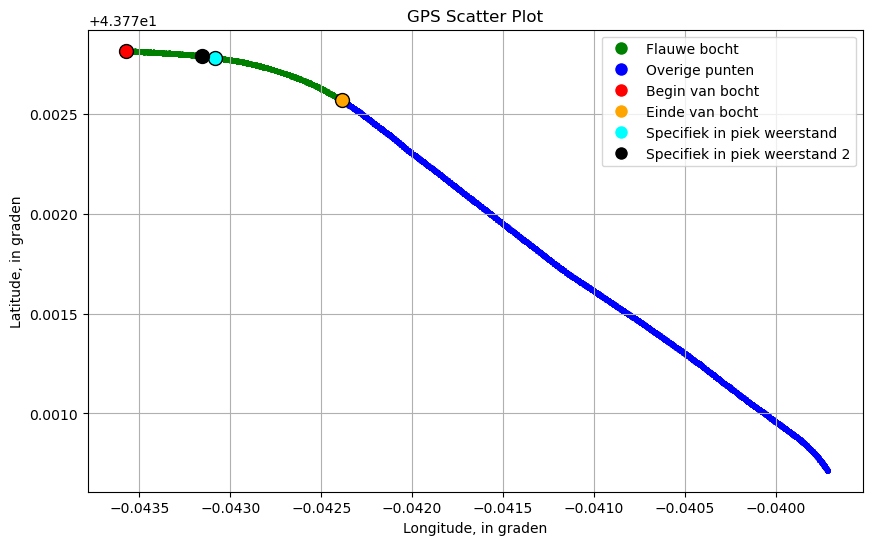

In [124]:
import matplotlib.pyplot as plt

# Stel de DataFrame opnieuw samen voor het rechte stuk
rechte_stuk_ronde7 = filtered_motordriver.loc[388561:394865]

# Bereid een kleurenarray voor alle punten, standaard ingesteld op blauw
colors = ['blue'] * len(rechte_stuk_ronde7)

# Vind de indices van de specifieke punten en zet de kleur naar groen
special_indices = [388565,390150]
index_positions = [rechte_stuk_ronde7.index.get_loc(idx) for idx in special_indices if idx in rechte_stuk_ronde7.index]

# Als beide indices gevonden zijn, kleur alle punten tussen deze indices groen
if len(index_positions) == 2:
    start_pos, end_pos = sorted(index_positions)  # Zorg ervoor dat start_pos < end_pos
    for i in range(start_pos, end_pos + 1):
        colors[i] = 'green'
    # Zet de eerste waarde op rood en de laatste op oranje
    colors[start_pos] = 'red'
    colors[end_pos] = 'orange'

# Specifiek punt op rij 389221 instellen op cyan
if 389221 in rechte_stuk_ronde7.index:
    cyan_pos = rechte_stuk_ronde7.index.get_loc(389221)
    colors[cyan_pos] = 'cyan'
    
if 389141 in rechte_stuk_ronde7.index:
    black_pos = rechte_stuk_ronde7.index.get_loc(389141)
    colors[black_pos] = 'black'

# Maak de scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    rechte_stuk_ronde7['GPS longitude, in graden'],
    rechte_stuk_ronde7['GPS latitude, in graden'],
    color=colors,
    s=10  # Standaard grootte van de punten
)

# Extra's toevoegen
plt.title('GPS Scatter Plot')
plt.xlabel('Longitude, in graden')
plt.ylabel('Latitude, in graden')
plt.grid(True)

# Vergroot de grootte van de speciale punten (rood, oranje en cyan) voor betere zichtbaarheid
for i in [start_pos, end_pos, cyan_pos, black_pos]:
    plt.scatter(
        rechte_stuk_ronde7.iloc[i]['GPS longitude, in graden'],
        rechte_stuk_ronde7.iloc[i]['GPS latitude, in graden'],
        color=colors[i],
        s=100,  # Grotere grootte voor de speciale punten
        edgecolor='black'  # Voeg een rand toe voor betere zichtbaarheid
    )

# Legenda toevoegen
green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Flauwe bocht')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Overige punten')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Begin van bocht')
orange_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Einde van bocht')
cyan_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=10, label='Specifiek in piek weerstand')
black_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Specifiek in piek weerstand 2')
plt.legend(handles=[green_patch, blue_patch, red_patch, orange_patch, cyan_patch, black_patch])

# Toon de plot
plt.show()


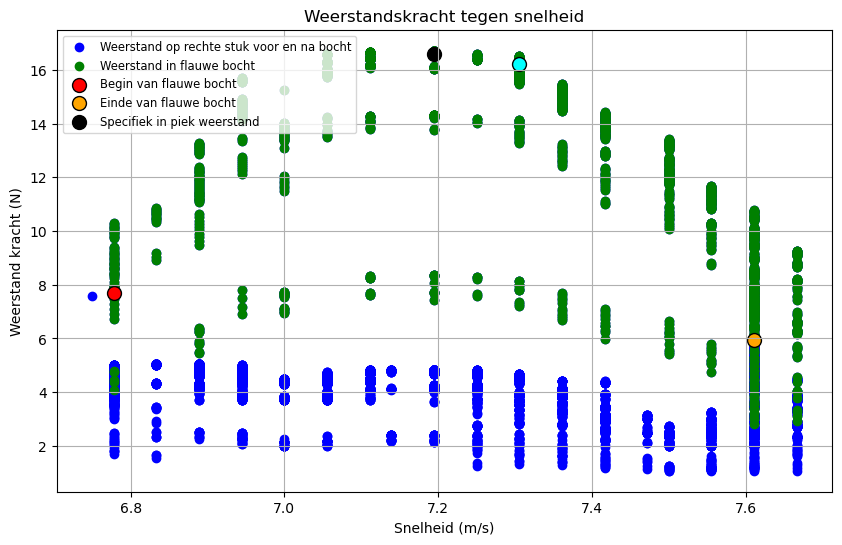

In [123]:
import matplotlib.pyplot as plt
#Met GPS snelheid

df_e_kin = df_e_kin[(df_combined['Weerstand (N)'] >= 0) & (df_combined['Weerstand (N)'] <= 20)]
df_e_kin = df_e_kin[(df_combined['Weerstand met GPS Snelheid (N)'] >= 0) & (df_combined['Weerstand met GPS Snelheid (N)'] <= 20)]

# Eerst, laten we de data voor de specifieke index range voorbereiden
specifieke_indices = df_combined.loc[388565:390150]

plt.figure(figsize=(10, 6))

# Teken alle punten in blauw
plt.scatter(df_combined["Gemeten_snelheden_GPS (m/s)"], df_combined['Weerstand (N)'],
            label='Weerstand op rechte stuk voor en na bocht', color='b')

# Teken nu de specifieke punten in het groen
plt.scatter(specifieke_indices["Gemeten_snelheden_GPS (m/s)"], specifieke_indices['Weerstand (N)'],
            color='green', label='Weerstand in flauwe bocht')

# Markeer het beginpunt met rood
plt.scatter(df_combined.loc[388565, "Gemeten_snelheden_GPS (m/s)"], df_combined.loc[388565, 'Weerstand (N)'],
            color='red', label='Begin van flauwe bocht', s=100, edgecolor='black')

# Markeer het eindpunt met oranje
plt.scatter(df_combined.loc[390150, "Gemeten_snelheden_GPS (m/s)"], df_combined.loc[390150, 'Weerstand (N)'],
            color='orange', label='Einde van flauwe bocht', s=100, edgecolor='black')

# Markeer een ander specifiek punt met cyan
plt.scatter(df_combined.loc[389221, "Gemeten_snelheden_GPS (m/s)"], df_combined.loc[389221, 'Weerstand (N)'],
            color='cyan', label='Specifiek in piek weerstand', s=100, edgecolor='black')

plt.scatter(df_combined.loc[389141, "Gemeten_snelheden_GPS (m/s)"], df_combined.loc[389141, 'Weerstand (N)'],
            color='black', label='Specifiek in piek weerstand', s=100, edgecolor='black')



plt.title('Weerstandskracht tegen snelheid')
plt.xlabel('Snelheid (m/s)')
plt.ylabel('Weerstand kracht (N)')
plt.grid(True)

# We passen de legenda aan zodat elk label maar één keer verschijnt
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Verwijder duplicaten

# Pas de legenda aan: kleinere lettergrootte en plaatsing linksboven
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize='small')

plt.show()


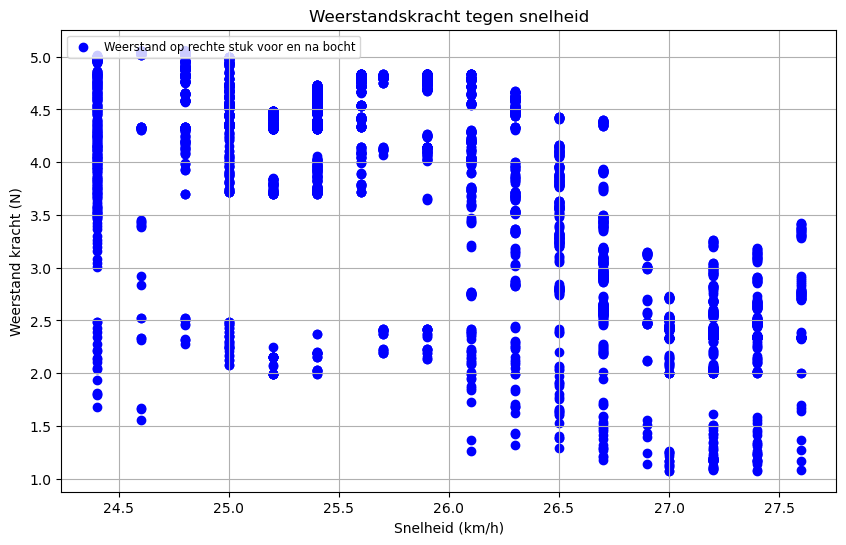

In [134]:
import matplotlib.pyplot as plt
#Met GPS snelheid

df_e_kin = df_e_kin[(df_e_kin['Weerstand (N)'] >= 0) & (df_e_kin['Weerstand (N)'] <= 20)]
df_e_kin = df_e_kin[(df_e_kin['Weerstand met GPS Snelheid (N)'] >= 0) & (df_e_kin['Weerstand met GPS Snelheid (N)'] <= 20)]

df_rechte_stuk = df_e_kin.loc[390500:]

# Eerst, laten we de data voor de specifieke index range voorbereiden
specifieke_indices = df_e_kin.loc[388565:390150]

plt.figure(figsize=(10, 6))

# Teken alle punten in blauw
plt.scatter(df_rechte_stuk["Gemeten_snelheden_GPS (m/s)"]*3.6, df_rechte_stuk['Weerstand (N)'],
            label='Weerstand op rechte stuk voor en na bocht', color='b')

# # Teken nu de specifieke punten in het groen
# plt.scatter(specifieke_indices["Gemeten_snelheden_GPS (m/s)"], specifieke_indices['Weerstand (N)'],
#             color='green', label='Weerstand in flauwe bocht')
# 
# # Markeer het beginpunt met rood
# plt.scatter(df_e_kin.loc[388565, "Gemeten_snelheden_GPS (m/s)"], df_e_kin.loc[388565, 'Weerstand (N)'],
#             color='red', label='Begin van flauwe bocht', s=100, edgecolor='black')
# 
# # Markeer het eindpunt met oranje
# plt.scatter(df_e_kin.loc[390150, "Gemeten_snelheden_GPS (m/s)"], df_e_kin.loc[390150, 'Weerstand (N)'],
#             color='orange', label='Einde van flauwe bocht', s=100, edgecolor='black')
# 
# # Markeer een ander specifiek punt met cyan
# plt.scatter(df_e_kin.loc[389221, "Gemeten_snelheden_GPS (m/s)"], df_e_kin.loc[389221, 'Weerstand (N)'],
#             color='cyan', label='Specifiek in piek weerstand', s=100, edgecolor='black')
# 
# plt.scatter(df_e_kin.loc[389141, "Gemeten_snelheden_GPS (m/s)"], df_e_kin.loc[389141, 'Weerstand (N)'],
#             color='black', label='Specifiek in piek weerstand', s=100, edgecolor='black')



plt.title('Weerstandskracht tegen snelheid')
plt.xlabel('Snelheid (km/h)')
plt.ylabel('Weerstand kracht (N)')
plt.grid(True)

# We passen de legenda aan zodat elk label maar één keer verschijnt
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Verwijder duplicaten

# Pas de legenda aan: kleinere lettergrootte en plaatsing linksboven
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize='small')

plt.show()


In [129]:
df_e_kin

,Afgelegde afstand (m),Gemeten_snelheden_GPS (m/s),Gemeten Snelheid (m/s),Kinetische Energie (J),Kinetische Energie met GPS snelheid (J),Potentiële Energie Totaal (J),Totale Energie (J),Totale Energie met GPS snelheid (J),Totale theoretische Energie met GPS snelheid (J),Energie vershil met GPS snelheid (J),Totale theoretische energie (J),Energie vershil (J),delta energie met GPS snelheid (J),delta afstand,delta energie (J),Weerstand met GPS Snelheid (N),Weerstand (N)
388562,10512.22,6.750000,6.845278,2108.602253,2050.312500,4722.982520,6831.584773,6773.295020,6824.687218,51.392198,6816.324721,-15.260052,0.454698,0.06,-15.260052,7.578293,7.578293
388564,10512.35,6.777778,6.848056,2110.313920,2067.222222,4722.070545,6832.384465,6789.292767,6824.692369,35.399602,6816.329872,-16.054593,0.459849,0.06,-3.989040,7.664150,7.664150
388565,10512.41,6.777778,6.861944,2118.882670,2067.222222,4721.610696,6840.493366,6788.832918,6824.694933,35.862015,6816.332436,-24.160930,0.462413,0.06,-8.106337,7.706883,7.706883
388566,10512.47,6.777778,6.845833,2108.944531,2067.222222,4721.148283,6830.092814,6788.370505,6824.697489,36.326984,6816.334993,-13.757822,0.464969,0.06,10.403108,7.749487,7.749487
388567,10512.53,6.777778,6.888611,2135.383337,2067.222222,4720.683314,6856.066651,6787.905536,6824.700038,36.794502,6816.337541,-39.729110,0.467518,0.06,-25.971288,7.791962,7.791962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394857,10914.23,6.833333,6.787500,2073.157031,2101.250000,2363.298364,4436.455395,4464.548364,6824.435610,2359.887246,6816.073113,2379.617718,0.203090,0.06,91.286184,3.384831,3.384831
394859,10914.36,6.833333,6.790556,2075.024014,2101.250000,2362.892754,4437.916768,4464.142754,6824.434468,2360.291713,6816.071971,2378.155203,0.201948,0.13,93.060465,1.553444,1.553444
394861,10914.48,6.833333,6.776944,2066.713920,2101.250000,2362.489433,4429.203353,4463.739433,6824.433317,2360.693883,6816.070820,2386.867467,0.200797,0.12,114.577047,1.673306,1.673306
394863,10914.60,6.833333,6.768889,2061.803556,2101.250000,2362.088419,4423.891974,4463.338419,6824.432157,2361.093738,6816.069660,2392.177686,0.199637,0.12,115.137206,1.663641,1.663641


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# Remove rows where acceleration, speed, or resistance is NaN or infinite
df_combined = df_combined[(df_combined['Weerstand (N)'] >= 0) & (df_combined['Weerstand (N)'] <= 20)]
df_combined = df_combined[(df_combined['Weerstand met GPS Snelheid (N)'] >= 0) & (df_combined['Weerstand met GPS Snelheid (N)'] <= 20)]
df_combined = df_combined.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
df_combined = df_combined.dropna(subset=['Weerstand met GPS Snelheid (N)', 'Weerstand (N)'])  # Drop rows with NaN in these columns

# Prepare the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Set up the latitude-longitude plot
ax1.set_ylim(df_combined['GPS latitude, in graden'].min() - 0.00001, df_combined['GPS latitude, in graden'].max() + 0.0001)
ax1.set_xlim(df_combined['GPS longitude, in graden'].min() - 0.00001, df_combined['GPS longitude, in graden'].max() + 0.00001)
ax1.set_xlabel("Latitude")
ax1.set_ylabel("Longitude")
ax1.set_title("Latitude and Longitude with Acceleration Coloring")

# Set up the speed comparison plot
ax2.set_xlim(df_combined['GPS speed, in km/h'].min() - 1, 
             df_combined['GPS speed, in km/h'].max() + 1)
ax2.set_ylim(df_combined['Weerstand met GPS Snelheid (N)'].min() - 5, 
             df_combined['Weerstand met GPS Snelheid (N)'].max() + 5)
ax2.set_xlabel("GPS speed, in km/h")
ax2.set_ylabel("Weerstand met GPS Snelheid (N)")
ax2.set_title("Weerstand tegen snelheid")

# Initialize scatter plots
scat1 = ax1.scatter([], [], alpha=0.7)
scat2 = ax2.scatter([], [], alpha=0.7)

# Add a legend for acceleration categories
legend_labels = [
    ('red', 'Voor bocht'),
    ('blue', 'In bocht'),
    ('yellow', 'Na bocht')
]
for color, label in legend_labels:
    ax2.scatter([], [], color=color, label=label)  # Dummy points for legend
ax2.legend(title="Kleurenlegenda", loc='upper left')

# Define the update function
def update(frame):
    end = frame + 1  # Display one additional row per frame
    if end > len(df_combined):  # Stop when all data is shown
        return

    # Extract data chunk
    chunk = df_combined.iloc[:end]  # Include all data up to the current frame
    
    # Determine colors for acceleration
    colors = chunk.index.map(
    lambda i: 'red' if i < 388565 else ('blue' if i <= 390150 else 'yellow'))

    # Update the latitude-longitude scatter plot
    # Update de GPS-plot
    chunk_lon = chunk['GPS longitude, in graden']
    chunk_lat = chunk['GPS latitude, in graden']
    scat1.set_offsets(np.column_stack((chunk_lon, chunk_lat)))
    scat1.set_color(colors)

    
    # Update the speed comparison plot
    scat2.set_offsets(np.column_stack((chunk['GPS speed, in km/h'],
                                        chunk['Weerstand met GPS Snelheid (N)'])))
    scat2.set_color(colors)

    return scat1, scat2

# Stel de animatie in
frames_count = len(df_combined)
anim = FuncAnimation(fig, update, frames=frames_count, repeat=False, interval=5, blit=True) #with 50ms per frame

# Custom dark mode CSS
dark_mode_css = """
<style>
    body {
        background-color: #121212;
        color: white;
    }
    .animation-container {
        background-color: #121212;
        border: 2px solid #ffffff;
        border-radius: 10px;
        padding: 20px;
    }   
</style>
"""

# Save as an HTML file
output_path = "dynamic_lat_lon_weerstand.html"
from matplotlib.animation import HTMLWriter
html_writer = HTMLWriter()
anim.save(output_path, writer=html_writer, dpi=80)

# Append the dark mode CSS to the HTML
with open(output_path, 'a') as f:
    f.write(dark_mode_css)

print(f"Animation saved as {output_path} with dark mode")

Animatie opgeslagen als dynamic_lat_lon_weerstand_recht_stuk_iets_langer.html.


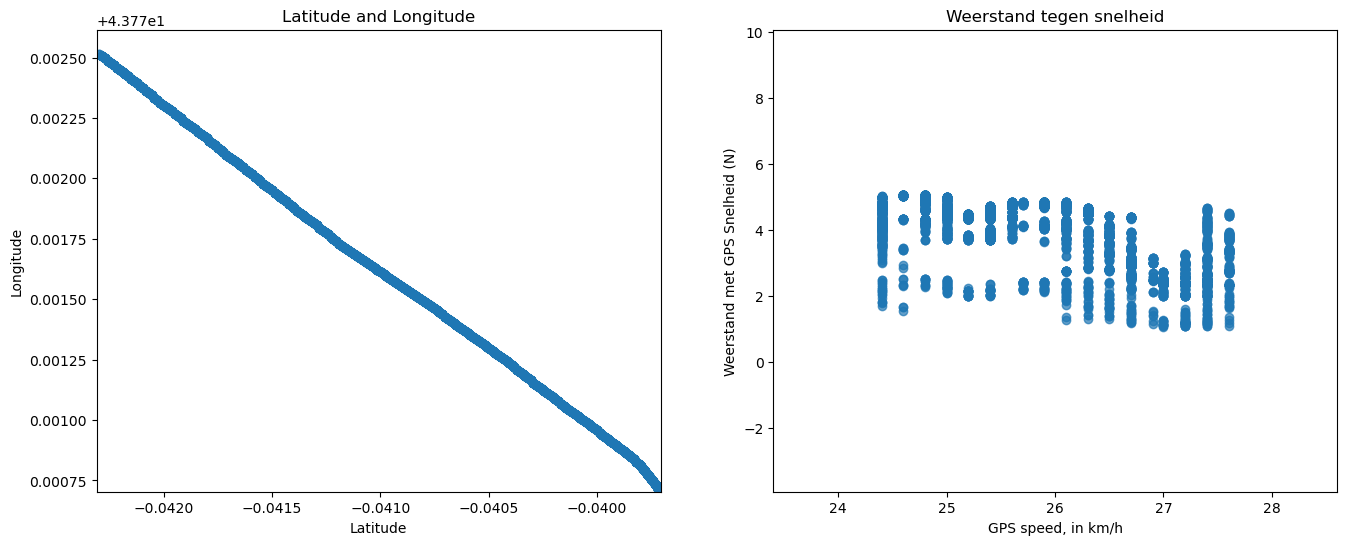

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Filter alles boven 20N weg
df_combined = df_combined[(df_combined['Weerstand (N)'] >= 0) & (df_combined['Weerstand (N)'] <= 20)]
df_combined = df_combined[(df_combined['Weerstand met GPS Snelheid (N)'] >= 0) & (df_combined['Weerstand met GPS Snelheid (N)'] <= 20)]
# Verwijder rijen met NaN of oneindige waarden in de relevante kolommen
df_combined = df_combined.replace([np.inf, -np.inf], np.nan)
df_combined = df_combined.dropna(subset=['Weerstand met GPS Snelheid (N)', 'Weerstand (N)'])

# Filter de DataFrame om alleen gegevens vanaf index 390500 op te nemen
animatie_rechtstuk = df_combined.loc[390300:]

# Bereid de figuur voor
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Instellingen voor de latitude-longitude plot
ax1.set_ylim(animatie_rechtstuk['GPS latitude, in graden'].min() - 0.00001, animatie_rechtstuk['GPS latitude, in graden'].max() + 0.0001)
ax1.set_xlim(animatie_rechtstuk['GPS longitude, in graden'].min() - 0.00001, animatie_rechtstuk['GPS longitude, in graden'].max() + 0.00001)
ax1.set_xlabel("Latitude")
ax1.set_ylabel("Longitude")
ax1.set_title("Latitude and Longitude")

# Instellingen voor de snelheid-weerstand plot
ax2.set_xlim(animatie_rechtstuk['GPS speed, in km/h'].min() - 1, animatie_rechtstuk['GPS speed, in km/h'].max() + 1)
ax2.set_ylim(animatie_rechtstuk['Weerstand met GPS Snelheid (N)'].min() - 5, animatie_rechtstuk['Weerstand met GPS Snelheid (N)'].max() + 5)
ax2.set_xlabel("GPS speed, in km/h")
ax2.set_ylabel("Weerstand met GPS Snelheid (N)")
ax2.set_title("Weerstand tegen snelheid")

# Initialiseer scatter plots
scat1 = ax1.scatter([], [], alpha=0.7)
scat2 = ax2.scatter([], [], alpha=0.7)

# Definieer de updatefunctie
def update(frame):
    end = frame + 1  # Toon één extra rij per frame
    if end > len(animatie_rechtstuk):  # Stop wanneer alle data is weergegeven
        return scat1, scat2

    # Haal het huidige datachunk op
    chunk = animatie_rechtstuk.iloc[:end]

    # Update de GPS-plot
    chunk_lon = chunk['GPS longitude, in graden']
    chunk_lat = chunk['GPS latitude, in graden']
    scat1.set_offsets(np.column_stack((chunk_lon, chunk_lat)))

    # Update de snelheid-weerstand plot
    scat2.set_offsets(np.column_stack((chunk['GPS speed, in km/h'],
                                       chunk['Weerstand met GPS Snelheid (N)'])))

    return scat1, scat2

# Stel de animatie in
frames_count = len(animatie_rechtstuk)
anim = FuncAnimation(fig, update, frames=frames_count, repeat=False, interval=50, blit=True)

# Sla op als MP4-bestand
output_path = "dynamic_lat_lon_weerstand_recht_stuk_iets_langer.html"
html_writer = HTMLWriter()
anim.save(output_path, writer=html_writer, dpi=80)

print(f"Animatie opgeslagen als {output_path}.")    
